In [2]:
import os
import sys
import anthropic
# import ollama
import random
import pandas as pd
from tqdm import tqdm
from google.generativeai.types import RequestOptions
from google.api_core import retry
from typing import List, Tuple
import json
from openai import OpenAI
import datetime

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [83]:
base_prompt = """
# General Instructions
You are a helpful assistant tasked with highlighting key facts in text. Given a question and answer pair, you should look at the answer and determine which sections of the text that were needed to answer the question. You are only concerned with identifying excerpts of the text that are ESSENTIAL to answering the question. You should ignore irrelevant information that does not help answer the final question. You should extract the exact parts of the text, not summarized versions of the text. After you have decided what specific quotes to use, tag the original question and answer with xml tags around those quotes. The xml tags should follow the format of <fact1>, <fact2>, etc. Every tag that you use in your answer should be also be included in the question as well. Here is what your response should look like:

### Fact Extraction Reasoning:
.... (this is your scratch pad to decide which information is most important)
(Feel free to be very verbose in this section to decide which information is important and which information is not essential enough to be tagged)

### Reformatted Text
...

# Fact Extraction Details
Each block of text has a large amount of information that could be a valid fact. However, you should only extract the most important quotes. Try to keep each quote decently short while still maintaining the essential information. All the tags in the "Question" section should be present in the "Answer" section.

Use the answer section to decide what information should be tagged. Specific details in the answer section are the most important. If a detail is not in the answer section, it is likely not essential enough to tag.

## Properly Done Example
Here is an example of properly extracting the information needed to answer the final question:

### Original Text:
Question: The following paragraphs each describe a set of seven objects arranged in a fixed order. The statements are logically consistent within each paragraph. In an antique car show, there are seven vehicles: a bus, a motorcyle, a hatchback, a station wagon, a minivan, a truck, and a limousine. The station wagon is the fourth-newest. The motorcyle is newer than the truck. The station wagon is older than the hatchback. The minivan is newer than the hatchback. The bus is newer than the minivan. The truck is newer than the limousine.
Options:
(A) The bus is the third-oldest
(B) The motorcyle is the third-oldest
(C) The hatchback is the third-oldest
(D) The station wagon is the third-oldest
(E) The minivan is the third-oldest
(F) The truck is the third-oldest
(G) The limousine is the third-oldest

Answer: To determine which vehicle is the third-oldest, we need to analyze the given facts:
1. **The station wagon is the fourth-newest**: This means there are three vehicles that are newer than the station wagon.
2. **The motorcycle is newer than the truck**: This indicates that the motorcycle is not the oldest and is positioned above the truck in terms of age.
3. **The station wagon is older than the hatchback**: This means the hatchback is newer than the station wagon.
4. **The minivan is newer than the hatchback**: This places the minivan above the hatchback in terms of age.
5. **The bus is newer than the minivan**: This means the bus is the newest among the minivan and the hatchback.
6. **The truck is newer than the limousine**: This indicates that the limousine is older than the truck.
Now, let's summarize the order based on the information:
- Since the station wagon is the fourth-newest, we can denote the order as follows:
  - 1st: Bus (newest)
  - 2nd: Minivan (newer than hatchback)
  - 3rd: Motorcycle (newer than truck)
  - 4th: Station Wagon (given)
  - 5th: Hatchback (older than station wagon)
  - 6th: Truck (newer than limousine)
  - 7th: Limousine (oldest)
From this arrangement, we can see that the third-oldest vehicle is the **motorcycle**. 
The answer is {B}.

### Fact Extraction Reasoning:
The question asks us to determine the third-oldest vehicle in the list. To answer this question, we need all the relative ages of the vehicles. I'll focus on just taging the specific ages of each of the vehicels in the text.

### Reformatted Text:
Question: The following paragraphs each describe a set of seven objects arranged in a fixed order. The statements are logically consistent within each paragraph. In an antique car show, there are seven vehicles: a bus, a motorcyle, a hatchback, a station wagon, a minivan, a truck, and a limousine. The <fact1>station wagon is the fourth-newest</fact1>. The <fact2>motorcyle is newer than the truck</fact2>. The <fact3>station wagon is older than the hatchback</fact3>. The <fact4>minivan is newer than the hatchback</fact4>. The <fact5>bus is newer than the minivan</fact5>. The <fact6>truck is newer than the limousine</fact6>.
Options:
(A) The bus is the third-oldest
(B) The motorcyle is the third-oldest
(C) The hatchback is the third-oldest
(D) The station wagon is the third-oldest
(E) The minivan is the third-oldest
(F) The truck is the third-oldest
(G) The limousine is the third-oldest

Answer: To determine which vehicle is the third-oldest, we need to analyze the given facts:
1. **<fact1>The station wagon is the fourth-newest</fact1>**: This means there are three vehicles that are newer than the station wagon.
2. **<fact2>The motorcycle is newer than the truck</fact2>**: This indicates that the motorcycle is not the oldest and is positioned above the truck in terms of age.
3. **<fact3>The station wagon is older than the hatchback</fact3>**: This means the hatchback is newer than the station wagon.
4. **<fact4>The minivan is newer than the hatchback</fact4>**: This places the minivan above the hatchback in terms of age.
5. **<fact5>The bus is newer than the minivan</fact5>**: This means the bus is the newest among the minivan and the hatchback.
6. **<fact6>The truck is newer than the limousine</fact6>**: This indicates that the limousine is older than the truck.
Now, let's summarize the order based on the information:
- Since the <fact1>station wagon is the fourth-newest</fact1>, we can denote the order as follows:
  - 1st: Bus (newest)
  - 2nd: Minivan (newer than hatchback)
  - 3rd: Motorcycle (newer than truck)
  - 4th: Station Wagon (given)
  - 5th: Hatchback (older than station wagon)
  - 6th: Truck (newer than limousine)
  - 7th: Limousine (oldest)
From this arrangement, we can see that the third-oldest vehicle is the **motorcycle**. 
The answer is {B}.

## What NOT to Extract
Given an inputted text, there are large amounts of possible facts that could be used. However, not all of these citations are relevant to the final question. You should only extract information that is essential to answering the question. Here is an example of a poorly tagged response that has too many extracted facts:

### Original Text:
Question: Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

Answer: Betty currently has half of the $100 she needs, which is $50. Her parents give her $15, and her grandparents give her twice that amount, which is $30. Adding the $15 from her parents and $30 from her grandparents to the $50 she already has, Betty now has $50 + $15 + $30 = $95. Since the wallet costs $100, she still needs $100 - $95 = $5 more to buy the wallet.

### Fact Extraction Reasoning:
...

### Reformatted Text:
Question: <fact1>Betty is saving money</fact1> for a <fact2>new wallet</fact2> which costs <fact3>$100</fact3>. <fact4>Betty has only half</fact4> of the <fact5>money she needs</fact5>. <fact6>Her parents decided to give</fact6> her <fact7>$15 for that purpose</fact7>, and <fact8>her grandparents twice as much as her parents</fact8>. <fact9>How much more money</fact9> <fact10>does Betty need to buy the wallet</fact10>?

Answer: <fact4>Betty currently has half</fact4> of the <fact3>$100</fact3> she needs, which is $50. <fact6>Her parents give her</fact6> <fact7>$15</fact7>, and <fact8>her grandparents give her twice that amount</fact8>, which is $30. Adding the <fact7>$15</fact7> from her parents and <fact8>$30</fact8> from her grandparents to the <fact4>$50 she already has</fact4>, Betty now has <fact4>$50</fact4> + <fact7>$15</fact7> + <fact8>$30</fact8> = $95. Since the wallet costs <fact3>$100</fact3>, she still needs <fact3>$100</fact3> - $95 = <fact11>$5 more to buy the</fact11> <fact2>wallet</fact2>.

While all of these tags do properly wrap the quotes from the original text, there are multiple mistakes in this example. Tags like <fact1>, <fact2>, <fact5>, etc contain information that is not essential to answering the final question. Additionally, the tags should be as concise as possible while still providing the necessary information. Many of these tags are redundant or overly verbose, making the response less clear and concise. Another key problem with this tagged example is that all the tags present in the question are not present in the answer. For example, <fact9> and <fact10> are present in the question but not in the answer. Similarly, <fact11> is present in the answer but not in the question. If a tag in the question cannot be tagged in the answer, do not make a tag of that information in the question. It is very important that the question has the same number of unique tags as the answer. Avoid making all of these mistakes in your response.

### Original Text:
Question: Could Mount Everest fit inside the Mariana Trench without reaching the surface?

Answer: The Mariana Trench is over 36,000 feet deep, while Mount Everest is about 29,000 feet tall, so the answer is true.

### Fact Extraction Reasoning:
...

### Reformatted Text:
Question: Could <fact1>Mount Everest</fact1> fit inside the Mariana Trench without reaching the surface?

Answer: The <fact2>Mariana Trench</fact2> is over 36,000 feet deep, while <fact2>Mount Everest</fact2> is about 29,000 feet tall, so the answer is true.

The mistake with this example is that there is a tag in the question that is not present in the answer. The answer has a tag for Mount Everest, but the question does not. There should always be an equal number of unique tags in the question and answer.

**Tag the following question:**
"""

In [96]:
base_prompt_backwards = """
# General Instructions
You are a helpful assistant tasked with highlighting key facts in text. Given a question and answer pair, you should look at the answer and determine which sections of the text that were needed to answer the question. You are only concerned with identifying excerpts of the text that are ESSENTIAL to answering the question. You should ignore irrelevant information that does not help answer the final question. You should extract the exact parts of the text, not summarized versions of the text. After you have decided what specific quotes to use, tag the original question and answer with xml tags around those quotes. The xml tags should follow the format of <fact1>, <fact2>, etc. Every tag that you use in your answer should be also be included in the question as well. Here is what your response should look like:

### Fact Extraction Reasoning:
.... (this is your scratch pad to decide which information is most important)

### Reformatted Text
...

# Reasoning Process
The primary goal of the "Fact Extraction Reasoning:" section is to give a place to think step by step on what information in the answer could also be tagged in the question. The second goal of this section is to think step by step about which information is important in the answer and which information is not essential enough to tag. Here is an improperly done example where the reasoning section is not properly thought through which results in a tag in the answer that does not appear in the question.

### Original Text:
Answer: Located in the western Pacific Ocean, the Mariana Trench is over 36,000 feet deep. However, the Mount Everest is about 29,000 feet tall, so the answer is true.

Question: Could Mount Everest fit inside the Mariana Trench without reaching the surface?

### Fact Extraction Reasoning:
...

### Reformatted Text:
Answer: Located in the <fact1>western Pacific Ocean</fact1>, <fact2>the Mariana Trench</fact2> is over 36,000 feet deep. However, the <fact3>Mount Everest</fact3> is about 29,000 feet tall, so the answer is true.

Question: Could <fact3>Mount Everest</fact3> fit inside the <fact2>Mariana Trench</fact2> without reaching the surface?

The mistake with this example is that there is a tag in the answer that is not present in the question. The answer has a tag for "western Pacific Ocean", but the question does not. There should always be an equal number of unique tags in the question and answer. If a tag in the answer cannot be tagged in the question, do not make a tag of that information in the answer. Therefore, in this response the tag for "western Pacific Ocean" should not be present in the answer.

# Fact Extraction Details
Each block of text has a large amount of information that could be a valid fact. However, you should only extract the most important quotes. Try to keep each quote decently short while still maintaining the essential information. All the tags in the "Question" section should be present in the "Answer" section. If a fact in the answer cannot be tagged to a fact in the question, do not tag that fact in the answer. Make sure to think through step by step in the reasoning section to ensure that you are only tagging the information that can be tagged in the question AND the answer.

Use the answer section to decide what information should be tagged. Specific details in the answer section are the most important. If a detail is not in the answer section, it is likely not essential enough to tag.

## Properly Done Example
Here is an example of properly extracting the information needed to answer the final question:

### Original Text:
Answer: To determine which vehicle is the third-oldest, we need to analyze the given facts:
1. **The station wagon is the fourth-newest**: This means there are three vehicles that are newer than the station wagon.
2. **The motorcycle is newer than the truck**: This indicates that the motorcycle is not the oldest and is positioned above the truck in terms of age.
3. **The station wagon is older than the hatchback**: This means the hatchback is newer than the station wagon.
4. **The minivan is newer than the hatchback**: This places the minivan above the hatchback in terms of age.
5. **The bus is newer than the minivan**: This means the bus is the newest among the minivan and the hatchback.
6. **The truck is newer than the limousine**: This indicates that the limousine is older than the truck.
Now, let's summarize the order based on the information:
- Since the station wagon is the fourth-newest, we can denote the order as follows:
  - 1st: Bus (newest)
  - 2nd: Minivan (newer than hatchback)
  - 3rd: Motorcycle (newer than truck)
  - 4th: Station Wagon (given)
  - 5th: Hatchback (older than station wagon)
  - 6th: Truck (newer than limousine)
  - 7th: Limousine (oldest)
From this arrangement, we can see that the third-oldest vehicle is the **motorcycle**. 
The answer is {B}.

Question: The following paragraphs each describe a set of seven objects arranged in a fixed order. The statements are logically consistent within each paragraph. In an antique car show, there are seven vehicles: a bus, a motorcyle, a hatchback, a station wagon, a minivan, a truck, and a limousine. The station wagon is the fourth-newest. The motorcyle is newer than the truck. The station wagon is older than the hatchback. The minivan is newer than the hatchback. The bus is newer than the minivan. The truck is newer than the limousine.
Options:
(A) The bus is the third-oldest
(B) The motorcyle is the third-oldest
(C) The hatchback is the third-oldest
(D) The station wagon is the third-oldest
(E) The minivan is the third-oldest
(F) The truck is the third-oldest
(G) The limousine is the third-oldest

### Fact Extraction Reasoning:
The question asks us to determine the third-oldest vehicle in the list. To answer this question, we need all the relative ages of the vehicles. I'll focus on just taging the specific ages of each of the vehicels in the text.

### Reformatted Text:
Answer: To determine which vehicle is the third-oldest, we need to analyze the given facts:
1. **<fact1>The station wagon is the fourth-newest</fact1>**: This means there are three vehicles that are newer than the station wagon.
2. **<fact2>The motorcycle is newer than the truck</fact2>**: This indicates that the motorcycle is not the oldest and is positioned above the truck in terms of age.
3. **<fact3>The station wagon is older than the hatchback</fact3>**: This means the hatchback is newer than the station wagon.
4. **<fact4>The minivan is newer than the hatchback</fact4>**: This places the minivan above the hatchback in terms of age.
5. **<fact5>The bus is newer than the minivan</fact5>**: This means the bus is the newest among the minivan and the hatchback.
6. **<fact6>The truck is newer than the limousine</fact6>**: This indicates that the limousine is older than the truck.
Now, let's summarize the order based on the information:
- Since the <fact1>station wagon is the fourth-newest</fact1>, we can denote the order as follows:
  - 1st: Bus (newest)
  - 2nd: Minivan (newer than hatchback)
  - 3rd: Motorcycle (newer than truck)
  - 4th: Station Wagon (given)
  - 5th: Hatchback (older than station wagon)
  - 6th: Truck (newer than limousine)
  - 7th: Limousine (oldest)
From this arrangement, we can see that the third-oldest vehicle is the **motorcycle**. 
The answer is {B}.

Question: The following paragraphs each describe a set of seven objects arranged in a fixed order. The statements are logically consistent within each paragraph. In an antique car show, there are seven vehicles: a bus, a motorcyle, a hatchback, a station wagon, a minivan, a truck, and a limousine. The <fact1>station wagon is the fourth-newest</fact1>. The <fact2>motorcyle is newer than the truck</fact2>. The <fact3>station wagon is older than the hatchback</fact3>. The <fact4>minivan is newer than the hatchback</fact4>. The <fact5>bus is newer than the minivan</fact5>. The <fact6>truck is newer than the limousine</fact6>.
Options:
(A) The bus is the third-oldest
(B) The motorcyle is the third-oldest
(C) The hatchback is the third-oldest
(D) The station wagon is the third-oldest
(E) The minivan is the third-oldest
(F) The truck is the third-oldest
(G) The limousine is the third-oldest

## What NOT to Extract
Given an inputted text, there are large amounts of possible facts that could be used. However, not all of these citations are relevant to the final question. You should only extract information that is essential to answering the question. Here is an example of a poorly tagged response that has too many extracted facts:

### Original Text:
Answer: Betty currently has half of the $100 she needs, which is $50. Her parents give her $15, and her grandparents give her twice that amount, which is $30. Adding the $15 from her parents and $30 from her grandparents to the $50 she already has, Betty now has $50 + $15 + $30 = $95. Since the wallet costs $100, she still needs $100 - $95 = $5 more to buy the wallet.

Question: Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

### Fact Extraction Reasoning:
...

### Reformatted Text:
Answer: <fact4>Betty currently has half</fact4> of the <fact3>$100</fact3> she needs, which is $50. <fact6>Her parents give her</fact6> <fact7>$15</fact7>, and <fact8>her grandparents give her twice that amount</fact8>, which is $30. Adding the <fact7>$15</fact7> from her parents and <fact8>$30</fact8> from her grandparents to the <fact4>$50 she already has</fact4>, Betty now has <fact4>$50</fact4> + <fact7>$15</fact7> + <fact8>$30</fact8> = $95. Since the wallet costs <fact3>$100</fact3>, she still needs <fact3>$100</fact3> - $95 = <fact11>$5 more to buy the</fact11> <fact2>wallet</fact2>.

Question: <fact1>Betty is saving money</fact1> for a <fact2>new wallet</fact2> which costs <fact3>$100</fact3>. <fact4>Betty has only half</fact4> of the <fact5>money she needs</fact5>. <fact6>Her parents decided to give</fact6> her <fact7>$15 for that purpose</fact7>, and <fact8>her grandparents twice as much as her parents</fact8>. <fact9>How much more money</fact9> <fact10>does Betty need to buy the wallet</fact10>?

While all of these tags do properly wrap the quotes from the original text, there are multiple mistakes in this example. Tags like <fact1>, <fact2>, <fact5>, etc contain information that is not essential to answering the final question. Additionally, the tags should be as concise as possible while still providing the necessary information. Many of these tags are redundant or overly verbose, making the response less clear and concise. Another key problem with this tagged example is that all the tags present in the question are not present in the answer. For example, <fact9> and <fact10> are present in the question but not in the answer. Similarly, <fact11> is present in the answer but not in the question. If a tag in the question cannot be tagged in the answer, do not make a tag of that information in the question. It is very important that the question has the same number of unique tags as the answer. Avoid making all of these mistakes in your response.

**Tag the following question:**
"""

In [33]:
questions = [
    """Question: We have three blocks, A, B and C. Block A has a medium blue square. Below block A is block B which has one medium black square. To the left of block B there is block C which has two medium blue squares. Medium blue square number one is below medium blue square number two. A medium yellow square is below medium blue square number two and medium blue square number one. What is to the left of the black thing? a medium blue square that is in block A or a medium blue square number two?
(a) medium blue square  that is in block A
(b) medium blue square  number two
(c) both of them
(d) none of them
Answer: Block A has a medium blue square, and Block B (below A) has a black square. Block C, to the left of Block B, has two medium blue squares, with blue square number two on top and number one below it. Since the blue squares in Block C are directly to the left of the black square in Block B.
The answer is {B}.
    """,
    """Question: We have two blocks. Lets call them A and B. There are two small yellow triangles in block A. Small yellow triangle number one is above and near to small yellow triangle number two. To the right of block A there is block B which contains one small blue triangle. To the left of and far from a small blue circle is a big blue circle. It is above the small blue triangle. The small blue triangle is touching the bottom edge of this block. To the right of the small blue triangle is the small blue circle. Which object is to the right of a small yellow triangle? the small blue circle or the small blue triangle that is touching the bottom edge of a block?
(a) the small blue circle
(b) the small blue triangle that is touching the bottom edge of a block
(c) both of them
(d) none of them
Answer: In block A, there are two small yellow triangles. To the right of block A, block B contains a small blue triangle touching the bottom edge and a small blue circle to its right. Since both the small blue circle and the small blue triangle are to the right of the small yellow triangles.
The answer is {C}.
    """,
    """Question: There are three blocks. We call them A, B and C. Block A contains two big black circles. There is also a small yellow triangle touching the bottom edge of this block. Big black circle number two is touching the right edge of this block. Big black circle number one is to the left of and near to big black circle number two. This shape is above the small yellow triangle. Above block A is block B with a big black triangle in it. Above block B there is block C. It contains two big yellow triangles. Big yellow triangle number one is touching the right edge of this block. It is above big yellow triangle number two. What is above the big black triangle? a small yellow triangle which is touching the bottom edge of a block or a big yellow triangle?
(a) small yellow triangle which is touching the bottom edge of a block
(b) big yellow triangle
(c) both of them
(d) none of them
Answer: Block A contains a small yellow triangle touching the bottom edge, and Block C (above Block B) contains two big yellow triangles, with big yellow triangle number one above big yellow triangle number two. Since Block C is directly above Block B (which contains the big black triangle), the object above the big black triangle is a big yellow triangle.
The answer is {B}.""",
"""Question: We have three blocks, A, B and C. Block B is below C. Block A is to the left of B. Block A contains a medium yellow triangle and a small yellow circle. The medium yellow triangle is to the left of and above the small yellow circle. Block B contains one small yellow triangle. And block C contains one medium yellow circle, one medium black circle and one small black circle. A medium blue circle is near to the small black circle. This object is near to and to the left of the medium yellow circle which is to the right of, near to and above the medium black circle. It is above the medium black circle. Which object is to the left of a small yellow triangle? the small yellow circle or the medium yellow circle?
(a) the small yellow circle
(b) the medium yellow circle
(c) both of them
(d) none of them
Answer: Block A contains a small yellow circle, and Block B contains a small yellow triangle. Since Block A is to the left of Block B, and the small yellow circle is in Block A, it is to the left of the small yellow triangle. The medium yellow circle, which is in Block C, is above and to the right of the small yellow triangle, but not to the left of it.
The answer is {A}.
""",
"""Question: There are two blocks, A and B. Block A has one big yellow triangle and a big black square. Below the big black square there is the big yellow triangle. It is touching the bottom edge of this block. It also contains one small yellow square. The big black square is to the left of and near to the small yellow square. Above block A we have block B which contains one big black triangle and a big black circle. The big black triangle is near to the big black circle. What is below the big black triangle? a big black square or a circle?
(a) big black square
(b) circle
(c) both of them
(d) none of them
Answer: Block A, which is below Block B, contains a big black square. Since the big black triangle is in Block B and Block A is directly below Block B, the object directly below the big black triangle is the big black square in Block A.
The answer is {A}.""",
"""Question: There are three blocks. Lets call them A, B and C. Block A contains a big blue circle and a medium black circle. The big blue circle is touching the bottom edge of this block. A big yellow circle is to the left of the medium black circle. The medium black circle is touching the right edge of this block. To the left of the medium black circle there is the big blue circle. It is below the yellow object which is to the left of the medium black circle. To the left of block A we have block B with a big blue square in it. Below block A there is block C which has a medium yellow square. This block also has one medium yellow circle. Above the medium yellow square there is the medium yellow circle. What is to the right of the big blue square? a medium yellow circle or a medium yellow square?
(a) medium yellow circle
(b) medium yellow square
(c) both of them
(d) none of them
Answer: Block B contains the big blue square, and Block C, which is below Block A, contains both the medium yellow square and the medium yellow circle. Since the medium yellow circle is above the medium yellow square and both are located in Block C, which is below Block A, neither of these objects is directly to the right of the big blue square in Block B.
The answer is {D}."""
             ]

In [69]:
questions_GSM = [
    """Question: Sam works at the Widget Factory, assembling Widgets. He can assemble 1 widget every 10 minutes. Jack from the loading dock can help assemble widgets when he doesn't have anything else to do. When he helps, they put together 2 complete widgets every 15 minutes. Recently the factory hired Tony to help assemble widgets. Being new to the job, he doesn't work as fast as Sam or Jack. Yesterday Sam worked for 6 hours before he had to leave work early for a dentist appointment. Jack was able to help out for 4 hours before he had to go back to the loading dock to unload a new shipment of widget materials. Tony worked the entire 8-hour shift. At the end of the day, they had completed 68 widgets. How long does it take Tony to assemble a Widget, in minutes?
Answer: Sam completes a widget every 10 minutes. 
When Jack helps they finish 2 in 15 minutes. Sam has finished 1 widget and has begun working on another one, and Jack finishes the second one at 15 minutes. So it takes Jack 15 minutes to complete a widget.
Sam worked for 6 hours yesterday, so he was able to complete 6 hours * 60 minutes per hour / 10 minutes per widget = 36 widgets.
Jack worked for 4 hours, so he was able to complete 4 hours * 60 minutes per hour / 15 minutes per widget = 16 widgets.
Sam, Jack, and Tony were able to complete 68 widgets together. So of those, Tony personally completed 68 widgets - 36 widgets - 16 widgets = 16 widgets.
It took Tony 8 hours to complete those 16 widgets, so he takes 8 hours * 60 minutes per hour / 16 widgets = 8*60/16=30 minutes per widget.
The answer is {30}.""",
"""Question: For every 12 cans you recycle, you receive $0.50, and for every 5 kilograms of newspapers, you receive $1.50. If your family collected 144 cans and 20 kilograms of newspapers, how much money would you receive?
Answer: There are 144/12 = 12 sets of 12 cans that the family collected. So, the family would receive $0.50 x 12 = $6 for the cans. There are 20/5 = 4 sets of 5 kilograms of newspapers that the family collected. So, the family would receive $1.50 x 4 = $6 for the newspapers. Therefore, the family would receive a total of $6 + $6 = $12.
The answer is {12}.""",
"""Question: A man is trying to maximize the amount of money he saves each month. In particular, he is trying to decide between two different apartments. The first apartment costs $800 per month in rent and will cost an additional $260 per month in utilities. The second apartment costs $900 per month and will cost an additional $200 per month in utilities. The first apartment is slightly further from the man's work, and the man would have to drive 31 miles per day to get to work. The second apartment is closer, and the man would only have to drive 21 miles to get to work. According to the IRS, each mile a person drives has an average cost of 58 cents. If the man must drive to work 20 days each month, what is the difference between the total monthly costs of these two apartments after factoring in utility and driving-related costs (to the nearest whole dollar)?
Answer: The mileage cost for the first apartment will be 31*20*0.58 = $359.60
This makes the total monthly cost of the first apartment 359.60 + 800 + 260 = $1419.60
Similarly, the mileage cost for the second apartment will be 21*20*0.58 = $243.60
Thus, the total monthly cost of the second apartment is 243.60 + 900 + 200 = 1343.60
Therefore, the difference in total monthly costs is 1419.60 - 1343.60 = $76
The answer is {76}.""",
"""Question: Ellie went to visit a circus with Sarah and they both got lost in the house of mirrors. They have to travel through the house of mirrors a few times before they finally get out and when they leave, they discuss how many times they've seen their own reflections. Sarah says that every time they were in the room with tall mirrors, she saw her reflection 10 times and every time they were in the room with wide mirrors, she saw her reflection 5 times. Ellie says that every time they were in the room with tall mirrors, she saw her reflection 6 times and every time they were in the room with wide mirrors she saw her reflection 3 times. They both passed through the room with tall mirrors 3 times each and they both passed through the room with wide mirrors 5 times each. In total, how many times did Sarah and Ellie see their reflections?
Answer: In the rooms with tall mirrors, Sarah saw her reflection a total of 10 reflections * 3 passes = 30 times.
In the rooms with wide mirrors, Sarah saw her reflection a total of 5 reflections * 5 passes = 25 reflections.
So Sarah saw her reflection a total of 30 + 25 = 55 times.
In the rooms with tall mirrors, Ellie saw her reflection a total of 6 reflections * 3 passes = 18 times.
In the rooms with wide mirrors, Ellie saw her reflection a total of 3 reflections * 5 passes = 15 times.
So Ellie saw her reflection a total of 18 + 15 = 33 times.
Therefore, Sarah and Ellie saw their reflections a total of 55 + 33 = 88 times.
The answer is {88}.""",
"""Question: A curry house sells curries that have varying levels of spice. Recently, a lot of the customers have been ordering very mild curries and the chefs have been having to throw away some wasted ingredients. To reduce cost and food wastage, the curry house starts monitoring how many ingredients are actually being used and changes their spending accordingly. The curry house needs 3 peppers for very spicy curries, 2 peppers for spicy curries, and only 1 pepper for mild curries. After adjusting their purchasing, the curry house now buys the exact amount of peppers they need. Previously, the curry house was buying enough peppers for 30 very spicy curries, 30 spicy curries, and 10 mild curries. They now buy enough peppers for 15 spicy curries and 90 mild curries. They no longer sell very spicy curries. How many fewer peppers does the curry house now buy?
Answer: The curry house previously bought 3 peppers per very spicy curry * 30 very spicy curries = 90 peppers for very spicy curries.
They also bought 2 peppers per spicy curry * 30 spicy curries = 60 peppers for spicy curries.
They also bought 1 pepper per mild curry * 10 mild curries = 10 peppers for mild curries.
So they were previously buying 90 + 60 + 10 = 160 peppers.
They now buy 2 peppers per spicy curry * 15 spicy curries = 30 peppers for spicy curries.
They also now buy 1 pepper per mild curry * 90 mild curries = 90 peppers for mild curries.
So they now buy 30 + 90 = 120 peppers.
This is a difference of 160 peppers bought originally - 120 peppers bought now = 40 peppers.
The answer is {40}.""",
"""Question: Betty picked 16 strawberries. Matthew picked 20 more strawberries than Betty and twice as many as Natalie. They used their strawberries to make jam. One jar of jam used 7 strawberries and they sold each jar at $4. How much money were they able to make from the strawberries they picked?
Answer: Matthew picked 16 + 20 = 36 strawberries. Natalie picked 36/2 = 18 strawberries. All together, they have 16 + 36 + 18 = 70 strawberries. They can make 70/7 = 10 jars of strawberries. They earn 10 x $4 = $40 from the strawberries they picked.
The answer is {40}.""",
"""Question: At the beginning of the day, Principal Kumar instructed Harold to raise the flag up the flagpole.  The flagpole is 60 feet long, and when fully raised, the flag sits on the very top of the flagpole.  Later that morning, Vice-principal Zizi instructed Harold to lower the flag to half-mast.  So, Harold lowered the flag halfway down the pole.   Later, Principal Kumar told Harold to raise the flag to the top of the pole once again, and Harold did just that.  At the end of the day, Vice-principal Zizi instructed Harold to completely lower the flag, take it off of the pole, and put it away for the evening.  Over the course of the day, how far, in feet, had the flag moved up and down the pole?
Answer: Half of the distance up the flagpole is 60/2 = 30 feet.
Thus, Harold moved the flag 60 up + 30 down + 30 up + 60 down = 180 feet.
The answer is {180}.""",
"""Question: Jo-Bob hopped into the hot air balloon, released the anchor rope, and pulled on the lift chain, which ignited the flame and provided the warm air that caused the balloon to rise.  When the lift chain was pulled, the balloon would rise at a rate of 50 feet per minute.  But when the chain was not being pulled, the balloon would slowly descend at a rate of 10 feet per minute.  During his balloon ride, he pulled the chain for 15 minutes, then released the rope for 10 minutes, then pulled the chain for another 15 minutes, and finally released the chain and allowed the balloon to slowly descend back to the earth.  During his balloon ride, what was the highest elevation reached by the balloon?
Answer: The first 15-minute chain pull caused the balloon to rise 50*15=750 feet.
Releasing the chain for 10 minutes caused the balloon to descend 10*10=100 feet.
The second 15-minute chain pull caused the balloon to rise another 50*15=750 feet.
Thus, at the end of the second chain pull, when the balloon was at its highest elevation, the balloon had risen to an elevation of 750-100+750=1400 feet above the earth's surface.
The answer is {1400}.""",
]

In [76]:
questions_StrategyQA = [
    """Question: At a presentation about post traumatic stress disorder, would Ariana Grande be a topic of relevance?
Answer: Ariana Grande was performing in Manchester in 2017 when explosives were set off in an act of terrorism.
Ariana Grande has spoken openly about her trauma experience and her PTSD regarding the Manchester Bombing.
So the answer is {true}.""",
    """Question: Has the Indian Ocean garbage patch not completed two full rotations of debris since its discovery?
Answer: The Indian Ocean garbage patch was discovered in 2010
The Indian Ocean garbage patch takes 6 years to complete a circulation 
So the answer is {true}.""",
    """Question: Was the Second Amendment to the United States Constitution written without consideration for black Americans?
Answer: The writers of the Constitutional Amendments did not view black people as legitimate human beings.
The writers of the Constitutional Amendments believed that slavery benefited black slaves.
The Constitutional Amendments were written for people that the writers considered human.
So the answer is {true}.""",
    """Question: Are Doctors of Homeopathy more likely than Doctors of Internal Medicine to recommend Quartz as a treatment?
Answer: Doctors of Homeopathy are practitioners of "alternative medicine" 
In alternative medicine practices, Quartz is believed to have powers.
Doctors of Internal Medicine have completed a medical residency and do not recommend alternative medicine.
So the answer is {true}.""",
    """Question: Is Benjamin Franklin a prime candidate to have his statues removed by Black Lives Matter movement?
Answer: The Black Lives Matter movement is a social movement advocating for racial equality.
Benjamin Franklin, a famous founding father, has his image on many monuments and on American currency.
Members of the Black Lives Matter movement petitioned for statues of Christopher Columbus to be removed due to his subjugation of Native Americans.
Benjamin Franklin's 1730s newspaper, The Philadelphia Gazette, posted ads for black slaves.
Benjamin Franklin owned two slaves, George and King, who worked as personal servants.
So the answer is {true}.""",
    """Question: Does the United States Department of Education oversee services benefiting undocumented migrants? 
Answer: The United States Department of Education oversees public education across the United States.
Public education is a service.
Public education services are given to students of migrant families that may be undocumented.
So the answer is {true}.""",
    """Question: Could Bernie Sanders visit the Metropolitan Museum of Art twenty times for under two hundred dollars?
Answer: Bernie Sanders is a senior citizen
Senior citizens from outside NY, NJ, or CT must pay $17 per visit
So the answer is {false}.""",
    """Question: Would Eric Clapton's mother hypothetically be unable to legally purchase cigarettes in the USA at his birth?
Answer: Eric Clapton's mother was 16 years old at the time of his birth.
As of 2020, federal law required states comply with a minimum age of 21 years for sale/purchase of tobacco products.
So the answer is {true}.
""",
    """Question: Would a 900,000 pound net worth person be an American billionaire if they exchange currency June 2020?
Answer: The exchange rate in June of 2020 between dollars and pounds is 1 Euro= 1.23 dollar.
900000 pounds is equal to about 1,107,000.00
So the answer is {true}.""",
]

In [88]:
questions_StrategyQA_backwards = [
    """Answer: Ariana Grande was performing in Manchester in 2017 when explosives were set off in an act of terrorism.
Ariana Grande has spoken openly about her trauma experience and her PTSD regarding the Manchester Bombing.
So the answer is {true}.
Question: At a presentation about post traumatic stress disorder, would Ariana Grande be a topic of relevance?
""",
    """Answer: The Indian Ocean garbage patch was discovered in 2010
The Indian Ocean garbage patch takes 6 years to complete a circulation 
So the answer is {true}.
Question: Has the Indian Ocean garbage patch not completed two full rotations of debris since its discovery?
""",
    """Answer: The writers of the Constitutional Amendments did not view black people as legitimate human beings.
The writers of the Constitutional Amendments believed that slavery benefited black slaves.
The Constitutional Amendments were written for people that the writers considered human.
So the answer is {true}.
Question: Was the Second Amendment to the United States Constitution written without consideration for black Americans?""",
    """
Answer: Doctors of Homeopathy are practitioners of "alternative medicine" 
In alternative medicine practices, Quartz is believed to have powers.
Doctors of Internal Medicine have completed a medical residency and do not recommend alternative medicine.
So the answer is {true}.
Question: Are Doctors of Homeopathy more likely than Doctors of Internal Medicine to recommend Quartz as a treatment?""",
    """
Answer: The Black Lives Matter movement is a social movement advocating for racial equality.
Benjamin Franklin, a famous founding father, has his image on many monuments and on American currency.
Members of the Black Lives Matter movement petitioned for statues of Christopher Columbus to be removed due to his subjugation of Native Americans.
Benjamin Franklin's 1730s newspaper, The Philadelphia Gazette, posted ads for black slaves.
Benjamin Franklin owned two slaves, George and King, who worked as personal servants.
So the answer is {true}.
Question: Is Benjamin Franklin a prime candidate to have his statues removed by Black Lives Matter movement?""",
    """Answer: The United States Department of Education oversees public education across the United States.
Public education is a service.
Public education services are given to students of migrant families that may be undocumented.
So the answer is {true}.""",
    """Answer: Bernie Sanders is a senior citizen
Senior citizens from outside NY, NJ, or CT must pay $17 per visit
So the answer is {false}.
Question: Could Bernie Sanders visit the Metropolitan Museum of Art twenty times for under two hundred dollars?""",
    """
Answer: Eric Clapton's mother was 16 years old at the time of his birth.
As of 2020, federal law required states comply with a minimum age of 21 years for sale/purchase of tobacco products.
So the answer is {true}.
Question: Would Eric Clapton's mother hypothetically be unable to legally purchase cigarettes in the USA at his birth?""",
    """Answer: The exchange rate in June of 2020 between dollars and pounds is 1 Euro= 1.23 dollar.
900000 pounds is equal to about 1,107,000.00
So the answer is {true}.
Question: Would a 900,000 pound net worth person be an American billionaire if they exchange currency June 2020?""",
]

In [46]:
answers = [
    """Reformatted Question: We have three blocks, A, B, and C. <fact1>Block A has a medium blue square</fact1>. <fact2>Below block A is block B, which has one medium black square</fact2>. <fact3>To the left of block B, there is block C, which has two medium blue squares</fact3>. <fact4>Medium blue square number one is below medium blue square number two</fact4>. A medium yellow square is below medium blue square number two and medium blue square number one. What is to the left of the black thing? A medium blue square that is in block A or a medium blue square number two?
Answer: <fact1>Block A has a medium blue square</fact1>, and <fact2>Block B (below A) has a black square</fact2>. <fact3>Block C, to the left of Block B, has two medium blue squares</fact3>, with <fact4>blue square number two on top and number one below it</fact4>. Since <fact3>the blue squares in Block C are directly to the left of the black square in Block B</fact3>, the object to the left of the black thing is medium blue square number two.
The answer is {B}.
    """,
    """
Reformatted Question: We have two blocks. Let's call them A and B. <fact1>There are two small yellow triangles in block A</fact1>. Small yellow triangle number one is above and near to small yellow triangle number two. <fact2>To the right of block A, there is block B which contains one small blue triangle</fact2>. The small blue triangle is touching the bottom edge of block B. <fact3>To the right of the small blue triangle is the small blue circle</fact3>. To the left of and far from a small blue circle is a big blue circle. It is above the small blue triangle. Which object is to the right of a small yellow triangle? The small blue circle or the small blue triangle that is touching the bottom edge of a block?
Answer: In block A, <fact1>there are two small yellow triangles</fact1>. To the right of block A, <fact2>block B contains a small blue triangle touching the bottom edge</fact2> and <fact3>a small blue circle to its right</fact3>. Since both the small blue circle and the small blue triangle are to the right of the small yellow triangles.
The answer is {C}.
""",
"""
Reformatted Question: There are three blocks. We call them A, B, and C. Block A contains two big black circles. <fact1>There is also a small yellow triangle touching the bottom edge of this block</fact1>. Big black circle number two is touching the right edge of this block. Big black circle number one is to the left of and near to big black circle number two. This shape is above the small yellow triangle. Above block A is block B with a big black triangle in it. <fact2>Above block B there is block C. It contains two big yellow triangles</fact2>. <fact3>Big yellow triangle number one is touching the right edge of this block</fact3>. It is above big yellow triangle number two. What is above the big black triangle? A small yellow triangle which is touching the bottom edge of a block or a big yellow triangle?
Answer: <fact1>Block A contains a small yellow triangle touching the bottom edge</fact1>, and <fact2>Block C (above Block B) contains two big yellow triangles</fact2>, with <fact3>big yellow triangle number one above big yellow triangle number two</fact3>. Since <fact2>Block C is directly above Block B (which contains the big black triangle)</fact2>, the object above the big black triangle is a big yellow triangle.
The answer is {B}.""",
"""
Reformatted Question: We have three blocks, A, B, and C. Block B is below C. <fact1>Block A is to the left of B</fact1>. <fact2>Block A contains a medium yellow triangle and a small yellow circle</fact2>. The medium yellow triangle is to the left of and above the small yellow circle. <fact3>Block B contains one small yellow triangle</fact3>. <fact4>Block C contains one medium yellow circle, one medium black circle, and one small black circle</fact4>. A medium blue circle is near to the small black circle. This object is near to and to the left of the medium yellow circle, which is to the right of, near to, and above the medium black circle. It is above the medium black circle. Which object is to the left of a small yellow triangle? The small yellow circle or the medium yellow circle?
Answer: <fact2>Block A contains a small yellow circle</fact2>, and <fact3>Block B contains a small yellow triangle</fact3>. Since <fact1>Block A is to the left of Block B</fact1>, and <fact2>the small yellow circle is in Block A</fact2>, it is to the left of the small yellow triangle. The <fact4>medium yellow circle, which is in Block C</fact4>, is above and to the right of the small yellow triangle, but not to the left of it.
The answer is {A}.""",
"""
Reformatted Question: There are two blocks, A and B. <fact1>Block A has one big yellow triangle and a big black square</fact1>. Below the big black square, there is the big yellow triangle. It is touching the bottom edge of this block. It also contains one small yellow square. The big black square is to the left of and near to the small yellow square. <fact2>Above block A we have block B, which contains one big black triangle and a big black circle</fact2>. The big black triangle is near to the big black circle. What is below the big black triangle? A big black square or a circle?
Answer: <fact1>Block A, which is below Block B, contains a big black square</fact1>. Since <fact2>the big black triangle is in Block B</fact2> and <fact1>Block A is directly below Block B</fact1>, the object directly below the big black triangle is the big black square in Block A.
The answer is {A}.""",
"""
Reformatted Question: There are three blocks. Let's call them A, B, and C. Block A contains a big blue circle and a medium black circle. The big blue circle is touching the bottom edge of this block. A big yellow circle is to the left of the medium black circle. The medium black circle is touching the right edge of this block. To the left of the medium black circle, there is the big blue circle. It is below the yellow object, which is to the left of the medium black circle. <fact1>To the left of block A, we have block B with a big blue square in it</fact1>. <fact2>Below block A, there is block C, which has a medium yellow square</fact2>. This block also has one medium yellow circle. <fact3>Above the medium yellow square, there is the medium yellow circle</fact3>. What is to the right of the big blue square? A medium yellow circle or a medium yellow square?
Answer: <fact1>Block B contains the big blue square</fact1>, and <fact2>Block C, which is below Block A, contains both the medium yellow square and the medium yellow circle</fact2>. Since <fact3>the medium yellow circle is above the medium yellow square</fact3> and both are located in Block C, which is below Block A, neither of these objects is directly to the right of the big blue square in Block B.
The answer is {D}."""   
]


In [70]:
answers_GSM = [
    """Question: Sam works at the Widget Factory, assembling Widgets. He can assemble 1 widget every 10 minutes. Jack from the loading dock can help assemble widgets when he doesn't have anything else to do. When he helps, they put together 2 complete widgets every 15 minutes. Recently the factory hired Tony to help assemble widgets. Being new to the job, he doesn't work as fast as Sam or Jack. Yesterday Sam worked for 6 hours before he had to leave work early for a dentist appointment. Jack was able to help out for 4 hours before he had to go back to the loading dock to unload a new shipment of widget materials. Tony worked the entire 8-hour shift. At the end of the day, they had completed 68 widgets. How long does it take Tony to assemble a Widget, in minutes?
Reformatted Question: <fact1>Sam works at the Widget Factory, assembling Widgets. He can assemble 1 widget every 10 minutes.</fact1> <fact2>Jack from the loading dock can help assemble widgets when he doesn't have anything else to do. When he helps, they put together 2 complete widgets every 15 minutes.</fact2> <fact3>Recently the factory hired Tony to help assemble widgets. Being new to the job, he doesn't work as fast as Sam or Jack.</fact3> <fact4>Yesterday Sam worked for 6 hours</fact4> before he had to leave work early for a dentist appointment. <fact5>Jack was able to help out for 4 hours</fact5> before he had to go back to the loading dock to unload a new shipment of widget materials. <fact6>Tony worked the entire 8-hour shift.</fact6> At the end of the day, <fact7>they had completed 68 widgets.</fact7> How long does it take <fact8>Tony to assemble a Widget</fact8>, in minutes?
Answer: <fact1>Sam completes a widget every 10 minutes</fact1>. 
<fact2>When Jack helps they finish 2 in 15 minutes</fact2>. Sam has finished 1 widget and has begun working on another one, and <fact2>Jack finishes the second one at 15 minutes</fact2>. So <fact2>it takes Jack 15 minutes to complete a widget</fact2>.
<fact4>Sam worked for 6 hours yesterday</fact4>, so he was able to complete <fact4>6 hours</fact4> * 60 minutes per hour / <fact1>10 minutes per widget</fact1> = 36 widgets.
<fact5>Jack worked for 4 hours</fact5>, so he was able to complete <fact5>4 hours</fact5> * 60 minutes per hour / <fact2>15 minutes per widget</fact2> = 16 widgets.
Sam, Jack, and Tony were able to complete <fact7>68 widgets</fact7> together. So of those, Tony personally completed <fact7>68 widgets</fact7> - 36 widgets - 16 widgets = 16 widgets.
<fact6>It took Tony 8 hours</fact6> to complete those 16 widgets, so he takes <fact6>8 hours</fact6> * 60 minutes per hour / 16 widgets = <fact6>8</fact6>*60/16=30 minutes per widget.
The answer is {30}.""",
    """Question: For every 12 cans you recycle, you receive $0.50, and for every 5 kilograms of newspapers, you receive $1.50. If your family collected 144 cans and 20 kilograms of newspapers, how much money would you receive?
Reformatted Question: For <fact1>every 12 cans</fact1> you recycle, <fact2>you receive $0.50</fact2>, and for <fact3>every 5 kilograms of newspapers</fact3>, <fact4>you receive $1.50</fact4>. If your family collected <fact5>144 cans</fact5> and <fact6>20 kilograms of newspapers</fact6>, how much money would you receive?
Answer: There are <fact5>144</fact5>/<fact1>12</fact1> = 12 sets of <fact1>12 cans</fact1> that the family collected. So, the family would receive <fact2>$0.50</fact2> x 12 = $6 for the cans. There are <fact6>20</fact6>/<fact3>5</fact3> = 4 sets of <fact3>5 kilograms of newspapers</fact3> that the family collected. So, the family would receive <fact4>$1.50</fact4> x 4 = $6 for the newspapers. Therefore, the family would receive a total of $6 + $6 = $12.
The answer is {12}.""",
    """Question: A man is trying to maximize the amount of money he saves each month. In particular, he is trying to decide between two different apartments. The first apartment costs $800 per month in rent and will cost an additional $260 per month in utilities. The second apartment costs $900 per month and will cost an additional $200 per month in utilities. The first apartment is slightly further from the man's work, and the man would have to drive 31 miles per day to get to work. The second apartment is closer, and the man would only have to drive 21 miles to get to work. According to the IRS, each mile a person drives has an average cost of 58 cents. If the man must drive to work 20 days each month, what is the difference between the total monthly costs of these two apartments after factoring in utility and driving-related costs (to the nearest whole dollar)?
Reformatted Question: A man is trying to maximize the amount of money he saves each month. In particular, he is trying to decide between two different apartments. <fact1>The first apartment costs $800 per month in rent and will cost an additional $260 per month in utilities</fact1>. <fact2>The second apartment costs $900 per month and will cost an additional $200 per month in utilities</fact2>. <fact3>The first apartment is slightly further from the man's work, and the man would have to drive 31 miles per day to get to work</fact3>. <fact4>The second apartment is closer, and the man would only have to drive 21 miles to get to work</fact4>. According to the IRS, <fact5>each mile a person drives has an average cost of 58 cents</fact5>. If the man must <fact6>drive to work 20 days each month</fact6>, what is the difference between the total monthly costs of these two apartments after factoring in utility and driving-related costs (to the nearest whole dollar)?
Answer: The mileage cost for the first apartment will be <fact3>31</fact3>*<fact6>20</fact6>*<fact5>0.58</fact5> = $359.60
This makes the total monthly cost of the first apartment 359.60 + <fact1>800</fact1> + <fact1>260</fact1> = $1419.60
Similarly, the mileage cost for the second apartment will be <fact4>21</fact4>*<fact6>20</fact6>*<fact5>0.58</fact5> = $243.60
Thus, the total monthly cost of the second apartment is 243.60 + <fact2>900</fact2> + <fact2>200</fact2> = 1343.60
Therefore, the difference in total monthly costs is 1419.60 - 1343.60 = $76
The answer is {76}.
""",
    """Question: Ellie went to visit a circus with Sarah and they both got lost in the house of mirrors. They have to travel through the house of mirrors a few times before they finally get out and when they leave, they discuss how many times they've seen their own reflections. Sarah says that every time they were in the room with tall mirrors, she saw her reflection 10 times and every time they were in the room with wide mirrors, she saw her reflection 5 times. Ellie says that every time they were in the room with tall mirrors, she saw her reflection 6 times and every time they were in the room with wide mirrors she saw her reflection 3 times. They both passed through the room with tall mirrors 3 times each and they both passed through the room with wide mirrors 5 times each. In total, how many times did Sarah and Ellie see their reflections?
Reformatted Question: Ellie went to visit a circus with Sarah and they both got lost in the house of mirrors. They have to travel through the house of mirrors a few times before they finally get out and when they leave, they discuss how many times they've seen their own reflections. <fact1>Sarah says that every time they were in the room with tall mirrors, she saw her reflection 10 times</fact1> and <fact2>every time they were in the room with wide mirrors, she saw her reflection 5 times</fact2>. <fact3>Ellie says that every time they were in the room with tall mirrors, she saw her reflection 6 times</fact3> and <fact4>every time they were in the room with wide mirrors she saw her reflection 3 times</fact4>. They both <fact5>passed through the room with tall mirrors 3 times each</fact5> and they both <fact6>passed through the room with wide mirrors 5 times each</fact6>. In total, how many times did Sarah and Ellie see their reflections?
Answer: In the rooms with tall mirrors, Sarah saw her reflection a total of <fact1>10 reflections</fact1> * <fact5>3 passes</fact5> = 30 times.
In the rooms with wide mirrors, Sarah saw her reflection a total of <fact2>5 reflections</fact2> * <fact6>5 passes</fact6> = 25 reflections.
So Sarah saw her reflection a total of 30 + 25 = 55 times.
In the rooms with tall mirrors, Ellie saw her reflection a total of <fact3>6 reflections</fact3> * <fact5>3 passes</fact5> = 18 times.
In the rooms with wide mirrors, Ellie saw her reflection a total of <fact4>3 reflections</fact4> * <fact6>5 passes</fact6> = 15 times.
So Ellie saw her reflection a total of 18 + 15 = 33 times.
Therefore, Sarah and Ellie saw their reflections a total of 55 + 33 = 88 times.
The answer is {88}.""",
    """Question: A curry house sells curries that have varying levels of spice. Recently, a lot of the customers have been ordering very mild curries and the chefs have been having to throw away some wasted ingredients. To reduce cost and food wastage, the curry house starts monitoring how many ingredients are actually being used and changes their spending accordingly. The curry house needs 3 peppers for very spicy curries, 2 peppers for spicy curries, and only 1 pepper for mild curries. After adjusting their purchasing, the curry house now buys the exact amount of peppers they need. Previously, the curry house was buying enough peppers for 30 very spicy curries, 30 spicy curries, and 10 mild curries. They now buy enough peppers for 15 spicy curries and 90 mild curries. They no longer sell very spicy curries. How many fewer peppers does the curry house now buy?
Reformatted Question: A curry house sells curries that have varying levels of spice. Recently, a lot of the customers have been ordering very mild curries and the chefs have been having to throw away some wasted ingredients. To reduce cost and food wastage, the curry house starts monitoring how many ingredients are actually being used and changes their spending accordingly. The curry house needs <fact1>3 peppers for very spicy curries</fact1>, <fact2>2 peppers for spicy curries</fact2>, and <fact3>only 1 pepper for mild curries</fact3>. After adjusting their purchasing, the curry house now buys the exact amount of peppers they need. Previously, the curry house was buying enough peppers for <fact4>30 very spicy curries</fact4>, <fact5>30 spicy curries</fact5>, and <fact6>10 mild curries</fact6>. They now buy enough peppers for <fact7>15 spicy curries</fact7> and <fact8>90 mild curries</fact8>. They no longer sell very spicy curries. How many fewer peppers does the curry house now buy?
Answer: The curry house previously bought <fact1>3 peppers per very spicy curry</fact1> * <fact4>30 very spicy curries</fact4> = 90 peppers for very spicy curries.
They also bought <fact2>2 peppers per spicy curry</fact2> * <fact5>30 spicy curries</fact5> = 60 peppers for spicy curries.
They also bought <fact3>1 pepper per mild curry</fact3> * <fact6>10 mild curries</fact6> = 10 peppers for mild curries.
So they were previously buying 90 + 60 + 10 = 160 peppers.
They now buy <fact2>2 peppers per spicy curry</fact2> * <fact7>15 spicy curries</fact7> = 30 peppers for spicy curries.
They also now buy <fact3>1 pepper per mild curry</fact3> * <fact8>90 mild curries</fact8> = 90 peppers for mild curries.
So they now buy 30 + 90 = 120 peppers.
This is a difference of 160 peppers bought originally - 120 peppers bought now = 40 peppers.
The answer is {40}.""",
    """Question: Betty picked 16 strawberries. Matthew picked 20 more strawberries than Betty and twice as many as Natalie. They used their strawberries to make jam. One jar of jam used 7 strawberries and they sold each jar at $4. How much money were they able to make from the strawberries they picked?
Reformatted Question: <fact1>Betty picked 16 strawberries</fact1>. <fact2>Matthew picked 20 more strawberries than Betty</fact2> and <fact3>twice as many as Natalie</fact3>. They used their strawberries to make jam. <fact4>One jar of jam used 7 strawberries</fact4> and they <fact5>sold each jar at $4</fact5>. How much money were they able to make from the strawberries they picked?
Answer: Matthew picked <fact1>16</fact1> + <fact2>20</fact2> = 36 strawberries. Natalie picked 36/<fact3>2</fact3> = 18 strawberries. All together, they have <fact1>16</fact1> + 36 + 18 = 70 strawberries. They can make 70/<fact4>7</fact4> = 10 jars of strawberries. They earn 10 x <fact5>$4</fact5> = $40 from the strawberries they picked.
The answer is {40}.""",
    """Question: At the beginning of the day, Principal Kumar instructed Harold to raise the flag up the flagpole.  The flagpole is 60 feet long, and when fully raised, the flag sits on the very top of the flagpole.  Later that morning, Vice-principal Zizi instructed Harold to lower the flag to half-mast.  So, Harold lowered the flag halfway down the pole.   Later, Principal Kumar told Harold to raise the flag to the top of the pole once again, and Harold did just that.  At the end of the day, Vice-principal Zizi instructed Harold to completely lower the flag, take it off of the pole, and put it away for the evening.  Over the course of the day, how far, in feet, had the flag moved up and down the pole?
Reformatted Question: At the beginning of the day, <fact1>Principal Kumar instructed Harold to raise the flag up the flagpole</fact1>. <fact2>The flagpole is 60 feet long</fact2>, and when fully raised, the flag sits on the very top of the flagpole. Later that morning, Vice-principal Zizi instructed Harold to lower the flag to half-mast. So, <fact3>Harold lowered the flag halfway down the pole</fact3>. Later, <fact4>Principal Kumar told Harold to raise the flag to the top of the pole once again</fact4>, and Harold did just that. At the end of the day, <fact5>Vice-principal Zizi instructed Harold to completely lower the flag, take it off of the pole, and put it away for the evening</fact5>. Over the course of the day, how far, in feet, had the flag moved up and down the pole?
Answer: Half of the distance up the flagpole is <fact2>60</fact2>/2 = 30 feet.
Thus, Harold moved the flag <fact1>60 up</fact1> + <fact3>30 down</fact3> + <fact4>30 up</fact4> + <fact5>60 down</fact5> = 180 feet.
The answer is {180}.
""",
    """Question: Jo-Bob hopped into the hot air balloon, released the anchor rope, and pulled on the lift chain, which ignited the flame and provided the warm air that caused the balloon to rise.  When the lift chain was pulled, the balloon would rise at a rate of 50 feet per minute.  But when the chain was not being pulled, the balloon would slowly descend at a rate of 10 feet per minute.  During his balloon ride, he pulled the chain for 15 minutes, then released the rope for 10 minutes, then pulled the chain for another 15 minutes, and finally released the chain and allowed the balloon to slowly descend back to the earth.  During his balloon ride, what was the highest elevation reached by the balloon?
Reformatted Question: Jo-Bob hopped into the hot air balloon, released the anchor rope, and pulled on the lift chain, which ignited the flame and provided the warm air that caused the balloon to rise. When <fact1>the lift chain was pulled, the balloon would rise at a rate of 50 feet per minute</fact1>. But <fact2>when the chain was not being pulled, the balloon would slowly descend at a rate of 10 feet per minute</fact2>. During his balloon ride, he <fact3>pulled the chain for 15 minutes</fact3>, then <fact4>released the rope for 10 minutes</fact4>, then <fact5>pulled the chain for another 15 minutes</fact5>, and finally released the chain and allowed the balloon to slowly descend back to the earth. During his balloon ride, what was the highest elevation reached by the balloon?
Answer: The <fact1>first 15-minute</fact1> chain pull caused the balloon to rise <fact1>50</fact1>*<fact1>15</fact1>=750 feet.
Releasing the chain for <fact2>10 minutes</fact2> caused the balloon to descend <fact4>10</fact4>*<fact2>10</fact2>=100 feet.
The <fact5>second 15-minute</fact5> chain pull caused the balloon to rise another <fact1>50</fact1>*<fact5>15</fact5>=750 feet.
Thus, at the end of the second chain pull, when the balloon was at its highest elevation, the balloon had risen to an elevation of 750-100+750=1400 feet above the earth's surface.
The answer is {1400}.""",
]

In [101]:
answers_StrategyQA = [
    """Question: At a presentation about post traumatic stress disorder, would Ariana Grande be a topic of relevance?
Reformatted Question: At a presentation about <fact1>post traumatic stress disorder</fact1>, would <fact2>Ariana Grande</fact2> be a topic of relevance?
Answer: <fact2>Ariana Grande</fact2> was performing in Manchester in 2017 when explosives were set off in an act of terrorism.
<fact2>Ariana Grande</fact2> has spoken openly about <fact1>her trauma experience</fact1> and <fact1>her PTSD</fact1> regarding the Manchester Bombing.
So the answer is {true}.""",
    """Question: Has the Indian Ocean garbage patch not completed two full rotations of debris since its discovery?
Reformatted Question: Has the <fact1>Indian Ocean garbage patch</fact1> not completed <fact2>two full rotations of debris</fact2> since its discovery?
Answer: The <fact1>Indian Ocean garbage patch</fact1> was discovered in 2010.
The <fact1>Indian Ocean garbage patch</fact1> takes <fact2>6 years to complete a circulation</fact2>.
So the answer is {true}.""",
    """Question: Was the Second Amendment to the United States Constitution written without consideration for black Americans?
Reformatted Question: Was the <fact1>Second Amendment to the United States Constitution</fact1> written without consideration for <fact2>black Americans</fact2>?
Answer: The writers of the <fact1>Constitutional Amendments</fact1> did not view <fact2>black people</fact2> as legitimate human beings.
The writers of the <fact1>Constitutional Amendments</fact1> believed that slavery benefited <fact2>black slaves</fact2>.
The <fact1>Constitutional Amendments</fact1> were written for people that the writers considered human.
So the answer is {true}.""",
    """Question: Are Doctors of Homeopathy more likely than Doctors of Internal Medicine to recommend Quartz as a treatment?
Reformatted Question: Are <fact1>Doctors of Homeopathy</fact1> more likely than <fact2>Doctors of Internal Medicine</fact2> to recommend <fact3>Quartz</fact3> as a treatment?
Answer: <fact1>Doctors of Homeopathy</fact1> are practitioners of "alternative medicine."
In <fact1>alternative medicine</fact1> practices, <fact3>Quartz</fact3> is believed to have powers.
<fact2>Doctors of Internal Medicine</fact2> have completed a medical residency and do not recommend <fact1>alternative medicine</fact1>.
So the answer is {true}.""",
    """Question: Is Benjamin Franklin a prime candidate to have his statues removed by Black Lives Matter movement?
Reformatted Question: Is <fact1>Benjamin Franklin</fact1> a prime candidate to have his statues removed by the <fact2>Black Lives Matter movement</fact2>?
Answer: The <fact2>Black Lives Matter movement</fact2> is a social movement advocating for racial equality.
<fact1>Benjamin Franklin</fact1>, a famous founding father, has his image on many monuments and on American currency.
Members of the <fact2>Black Lives Matter movement</fact2> petitioned for statues of Christopher Columbus to be removed due to his subjugation of Native Americans.
<fact1>Benjamin Franklin</fact1>'s 1730s newspaper, The Philadelphia Gazette, posted ads for black slaves.
<fact1>Benjamin Franklin</fact1> owned two slaves, George and King, who worked as personal servants.
So the answer is {true}.""",
    """Question: Does the United States Department of Education oversee services benefiting undocumented migrants?
Reformatted Question: Does the <fact1>United States Department of Education</fact1> oversee services benefiting <fact2>undocumented migrants</fact2>?
Answer: The <fact1>United States Department of Education</fact1> oversees public education across the United States.
Public education is a service.
Public education services are given to students of migrant families that may be <fact2>undocumented</fact2>.
So the answer is {true}.""",
"""missing GT""",
    """Question: Would Eric Clapton's mother hypothetically be unable to legally purchase cigarettes in the USA at his birth?
Reformatted Question: Would <fact1>Eric Clapton's mother</fact1> hypothetically be unable to legally purchase <fact2>cigarettes</fact2> in the USA at his birth?
Answer: <fact1>Eric Clapton's mother</fact1> was 16 years old at the time of his birth.
As of 2020, federal law required states comply with a minimum age of 21 years for the sale/purchase of <fact2>tobacco products</fact2>.
So the answer is {true}.""",
]

In [97]:
def query_4o(prompt: str) -> str:
    client = OpenAI()

    completion = client.chat.completions.create(
        model="gpt-4o-2024-08-06",
        messages=[
            {
                "role": "user",
                "content": f"{prompt}"
            }
        ],
        temperature=0
    )

    return completion.choices[0].message.content

responses = []
for question in questions_StrategyQA_backwards:
    prompt = base_prompt_backwards + question
    responses.append(query_4o(prompt))
    # print(responses[-1])


In [66]:
with open("output.txt", "w") as file:
    # Write each string on a new line
    for string in responses:
        file.write(string + "\n")  # Add newline character at the end

In [44]:
import re
import os

def add_color_to_tags_new(text):
    """
    This function finds all unique tags in the text and assigns each a color from a predefined palette.
    It then replaces the tags with styled <span> elements that include the assigned background color.
    """
    # Find all unique opening tags in the text using regex
    tags = set(re.findall(r'<([A-Za-z]+\d*)>', text))

    # Predefined color palette
    color_palette = [
        'lightyellow', 'lightblue', 'lightgreen', 'lightcoral',
        'lightcyan', 'lightpink', 'lightsalmon', 'lightgray',
        'lightgoldenrodyellow', 'lightseagreen', 'lightskyblue',
        'lightsteelblue',
        'lavender', 'peachpuff', 'paleturquoise', 'wheat', 'mistyrose'
    ]

    # Dictionary to hold tag-color mapping
    tag_color_mapping = {}

    # Assign colors to tags, cycling through the color palette if necessary
    for i, tag in enumerate(sorted(tags)):
        color = color_palette[i % len(color_palette)]
        tag_color_mapping[tag] = color

    # Function to replace tags with styled spans including class names
    def replace_tag(match):
        tag = match.group(1)
        content = match.group(2)
        color = tag_color_mapping.get(tag, 'lightgray')  # Default color if not found
        return f'<span class="{tag}" style="background-color: {color}; font-weight: bold; padding: 2px 4px; border-radius: 3px;">{content}</span>'

    # Regex to find tags and replace them with styled spans
    # This regex handles multi-line content within tags
    tag_regex = re.compile(r'<([A-Za-z]+\d*)>\s*([\s\S]*?)\s*</\1>')

    # Replace all tags with styled spans
    text = tag_regex.sub(replace_tag, text)

    return text


def highlight_final_answer(text):
    """
    This function highlights the final answer enclosed in curly braces {}.
    """
    # Regex to find content within curly braces
    final_answer_regex = re.compile(r'\{([^}]+)\}')

    # Replace with a styled span
    highlighted_text = final_answer_regex.sub(
        lambda match: f'{match.group(1)}',
        text
    )

    return highlighted_text


def create_highlight_html(questions, output_file='questions_visualization.html'):
    """
    This function takes a list of question strings, applies color highlighting to any tags within them,
    and generates an HTML file to display the visualized questions.
    """
    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <title>Questions Visualization</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                margin: 20px;
                background-color: #f9f9f9;
            }}
            .container {{
                background-color: #ffffff;
                padding: 20px 25px;
                margin-bottom: 20px;
                border-radius: 8px;
                box-shadow: 0 2px 5px rgba(0,0,0,0.1);
            }}
            .question-header {{
                font-size: 1.3em;
                margin-bottom: 10px;
                color: #333333;
            }}
            .question-body {{
                font-size: 1.1em;
                line-height: 1.6;
                white-space: pre-wrap; /* Preserve line breaks */
            }}
            .final-answer {{
                margin-top: 15px;
                padding: 10px;
                background-color: #e6f7ff;
                border-left: 4px solid #1890ff;
                font-weight: bold;
            }}
            /* Styles for the highlighted spans */
            .highlighted {{
                padding: 2px 4px;
                border-radius: 3px;
                display: inline-block;
            }}
        </style>
    </head>
    <body>
    <h1>Questions Visualization</h1>
    <div class="summary">
        <strong>Total Questions:</strong> {total_questions}
    </div>
    <hr>
    """

    # Process each question and append to HTML content
    for idx, question in enumerate(questions, 1):
        try:
            # Apply color to tags in the question
            highlighted_question = add_color_to_tags_new(question)

            # Highlight the final answer enclosed in {}
            highlighted_question = highlight_final_answer(highlighted_question)

            # Build the HTML structure for each question
            html_content += f"<div class='container'>"
            html_content += f"<div class='question-header'><strong>Question {idx}:</strong></div>"
            html_content += f"<div class='question-body'>{highlighted_question}</div>"
            html_content += "</div>\n"
        except Exception as e:
            print(f"Cannot process question {idx}: {e}")
            continue

    # Close the HTML tags
    html_content += """
    </body>
    </html>
    """

    # Insert the total number of questions into the summary section
    html_content = html_content.format(total_questions=len(questions))

    # Write the HTML content to the output file
    with open(output_file, 'w', encoding='utf-8') as file:
        file.write(html_content)

    print(f"HTML content has been successfully written to {output_file}")


def main():
    """
    Main function to execute the visualization process.
    """
    # Define your array of string questions here

    # Specify the output HTML file name
    output_html_file = 'questions_visualization.html'

    # Generate the HTML visualization
    create_highlight_html(responses, output_html_file)


if __name__ == "__main__":
    main()


HTML content has been successfully written to questions_visualization.html


## responses + answers

In [102]:
import re
import os

def add_color_to_tags_new(text):
    """
    This function finds all unique tags in the text and assigns each a color from a predefined palette.
    It then replaces the tags with styled <span> elements that include the assigned background color.
    """
    # Find all unique opening tags in the text using regex
    tags = set(re.findall(r'<([A-Za-z]+\d*)>', text))

    # Predefined color palette
    color_palette = [
        'lightyellow', 'lightblue', 'lightgreen', 'lightcoral',
        'lightcyan', 'lightpink', 'lightsalmon', 'lightgray',
        'lightgoldenrodyellow', 'lightseagreen', 'lightskyblue',
        'lightsteelblue',
        'lavender', 'peachpuff', 'paleturquoise', 'wheat', 'mistyrose'
    ]

    # Dictionary to hold tag-color mapping
    tag_color_mapping = {}

    # Assign colors to tags, cycling through the color palette if necessary
    for i, tag in enumerate(sorted(tags)):
        color = color_palette[i % len(color_palette)]
        tag_color_mapping[tag] = color

    # Function to replace tags with styled spans including class names
    def replace_tag(match):
        tag = match.group(1)
        content = match.group(2)
        color = tag_color_mapping.get(tag, 'lightgray')  # Default color if not found
        return f'<span class="{tag}" style="background-color: {color}; font-weight: bold; border-radius: 3px;">{content}</span>'

    # Regex to find tags and replace them with styled spans
    # This regex handles multi-line content within tags
    tag_regex = re.compile(r'<([A-Za-z]+\d*)>\s*([\s\S]*?)\s*</\1>')

    # Replace all tags with styled spans
    text = tag_regex.sub(replace_tag, text)

    return text


def highlight_final_answer(text):
    """
    This function highlights the final answer enclosed in curly braces {}.
    """
    # Regex to find content within curly braces
    final_answer_regex = re.compile(r'\{([^}]+)\}')

    # Replace with a styled span
    highlighted_text = final_answer_regex.sub(
        lambda match: f'<span class="final-answer">{match.group(1)}</span>',
        text
    )

    return highlighted_text


def create_highlight_html(responses, answers, output_file='questions_visualization.html'):
    """
    This function takes lists of responses and answers, applies color highlighting to any tags within them,
    and generates an HTML file to display the visualized questions and answers side by side.
    """
    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <title>Questions and Answers Visualization</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                margin: 20px;
                background-color: #f9f9f9;
            }}
            .container {{
                background-color: #ffffff;
                padding: 20px 25px;
                margin-bottom: 20px;
                border-radius: 8px;
                box-shadow: 0 2px 5px rgba(0,0,0,0.1);
                display: flex;
                flex-direction: row;
                gap: 20px;
            }}
            .response, .answer {{
                flex: 1;
            }}
            .response-header, .answer-header {{
                font-size: 1.2em;
                margin-bottom: 10px;
                color: #333333;
                border-bottom: 2px solid #e0e0e0;
                padding-bottom: 5px;
            }}
            .response-body, .answer-body {{
                font-size: 1.1em;
                line-height: 1.6;
                white-space: pre-wrap; /* Preserve line breaks */
            }}
            .final-answer {{
                display: inline-block;
                margin-top: 15px;
                padding: 10px;
                background-color: #e6f7ff;
                border-left: 4px solid #1890ff;
                font-weight: bold;
                border-radius: 3px;
            }}
            /* Styles for the highlighted spans */
            .highlighted {{
                padding: 2px 4px;
                border-radius: 3px;
                display: inline-block;
            }}
            /* Responsive adjustments */
            @media (max-width: 768px) {{
                .container {{
                    flex-direction: column;
                }}
            }}
            .answer-body {{
                margin-top: 15rem;
            }}
        </style>
    </head>
    <body>
    <h1>Questions and Answers Visualization</h1>
    <div class="summary">
        <strong>Total Pairs:</strong> {total_pairs}
    </div>
    <hr>
    """

    # Ensure both lists have the same length
    total_pairs = min(len(responses), len(answers))

    # Process each pair and append to HTML content
    for idx in range(total_pairs):
        try:
            response = responses[idx]
            answer = answers[idx]

            # Apply color to tags in the response and answer
            highlighted_response = add_color_to_tags_new(response)
            highlighted_answer = add_color_to_tags_new(answer)

            # Highlight the final answer enclosed in {}
            highlighted_response = highlight_final_answer(highlighted_response)
            highlighted_answer = highlight_final_answer(highlighted_answer)

            # Build the HTML structure for each pair
            html_content += f"<div class='container'>"
            html_content += f"<div class='response'>"
            html_content += f"<div class='response-header'><strong>Response {idx + 1}:</strong></div>"
            html_content += f"<div class='response-body'>{highlighted_response}</div>"
            html_content += f"</div>"
            html_content += f"<div class='answer'>"
            html_content += f"<div class='answer-header'><strong>Answer {idx + 1}:</strong></div>"
            html_content += f"<div class='answer-body'>{highlighted_answer}</div>"
            html_content += f"</div>"
            html_content += "</div>\n"
        except Exception as e:
            print(f"Cannot process pair {idx + 1}: {e}")
            continue

    # Close the HTML tags
    html_content += """
    </body>
    </html>
    """

    # Insert the total number of pairs into the summary section
    html_content = html_content.format(total_pairs=total_pairs)

    # Write the HTML content to the output file
    with open(output_file, 'w', encoding='utf-8') as file:
        file.write(html_content)

    print(f"HTML content has been successfully written to {output_file}")


def main():

    # Ensure that the number of responses and answers match
    if len(responses) != len(answers):
        print("Warning: The number of responses and answers do not match. Only matching pairs will be processed.")

    # Specify the output HTML file name
    output_html_file = 'q_visualization_StrategyQA_backwards.html'

    # Generate the HTML visualization
    create_highlight_html(responses, answers_StrategyQA, output_html_file)


if __name__ == "__main__":
    main()


HTML content has been successfully written to q_visualization_StrategyQA_backwards.html


## manipulate CSV

In [2]:
import pandas as pd

def process_csv(input_file, output_file):
    # Read the CSV file
    df = pd.read_csv(input_file)
    
    def extract_question(answer_text):
        # Define the markers
        start_marker = "--------------- End of Conversation ---------------"
        end_marker = "--------------- Extracted Question ---------------"
        
        try:
            # Find the text between markers
            start_idx = answer_text.find(start_marker) + len(start_marker)
            end_idx = answer_text.find(end_marker)
            
            # Extract and clean the text if both markers are found
            if start_idx != -1 and end_idx != -1:
                return answer_text[start_idx:end_idx].strip()
            return ""
        except:
            return ""
    
    # Create new column with extracted questions
    df['extracted_question'] = df['answer'].apply(extract_question)
    
    # Save to new CSV file
    df.to_csv(output_file, index=False)

# Example usage
process_csv('/Users/log/Github/textual_grounding/logan/results/GSM8K/llama3.1/grounded_fact/multi_convo_None_llama3.1_1028_224532.csv', '/Users/log/Github/textual_grounding/logan/results/GSM8K/llama3.1/grounded_fact/multi_convo_data_extract_llama3.1_1028_224532.csv')

In [4]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/Users/log/Github/textual_grounding/logan/results/AQUA/4o/grounded_fact/multi_convo_None_4o_1027_225058.csv')

# Filter rows where 'extracted_question' doesn't contain '[' 
# Using raw string (r'\[') to properly handle the escape sequence
filtered_df = df[~df['extracted_question'].str.contains(r'\[', na=False)]

# Display the filtered questions
print("Questions without '[' character:")
for question in filtered_df['extracted_question']:
    print(question)

# Optionally, save to a new CSV
# filtered_df.to_csv('filtered_questions.csv', index=False)

Questions without '[' character:
If <fact1>27 bottles of soda cost A cents</fact1>, how much will B bottles cost in dollars?
On a normal day <fact1>Bill usually averages about 15 mph</fact1> when riding his bicycle. <fact2>On a windy day, his speed is reduced by 4 mph</fact2>. How far can Bill travel on a windy day in <fact3>21 minutes</fact3>? Round to the nearest hundredth.
Jerry purchased a 1-year <fact1>$5,000 bond</fact1> that paid an <fact2>annual interest rate of 12%</fact2> <fact3>compounded every six months</fact3>. How much interest had this bond accrued at maturity?
At a conference, one team is made up of <fact1>4 men and 4 women</fact1>. Four presenters are chosen to present the team's findings in front of the entire conference. How many different groups of presenters can be chosen from the team if a team <fact2>cannot be composed of men only or women only</fact2>? (Two groups of presenters are considered different if at least one presenter is different.)
A <fact1>cyclist t

In [3]:
import json
import random

def format_dataset(data_path: str, output_path: str):
    # Read the input JSONL file
    with open(data_path, 'r') as file:
        data = [json.loads(line) for line in file]

    formatted_data = []
    for idx, entry in enumerate(data):
        # Generate a unique ID
        entry["id"] = idx

        # Rename the original question
        entry["original_question"] = entry.pop("question", "")

        # Extract fields
        story = entry.get("story", "")
        original_question = entry.get("original_question", "")
        candidate_answers = entry.get("candidate_answers", [])
        
        # Format the combined string for the new "question" field
        combined_text = f"{story} {original_question}?"
        for i, answer in enumerate(candidate_answers):
            combined_text += f"\n{i}) {answer}"
        
        # Assign the combined text to the new "question" field
        entry["question"] = combined_text
        
        # Add the modified entry to the new list
        formatted_data.append(entry)
    
    # Save the formatted data to an output JSONL file
    with open(output_path, 'w') as file:
        for entry in formatted_data:
            file.write(json.dumps(entry) + "\n")

    print(f"Formatted dataset saved to {output_path}")
# Example usage
format_dataset('/Users/log/Github/spartqa-mchoice/spartqa_CO_test.jsonl', '/Users/log/Github/textual_grounding/data/SPARTQA/test.jsonl')


Formatted dataset saved to /Users/log/Github/textual_grounding/data/SPARTQA/test.jsonl


In [4]:
import os
import openai

client = openai.OpenAI(
    api_key=os.environ.get("SAMBANOVA_API_KEY"),
    base_url="https://api.sambanova.ai/v1",
)

response = client.chat.completions.create(
    model='Meta-Llama-3.1-8B-Instruct',
        messages=[
            {
                "role": "user",
                "content": "hello world",
            }
        ],
    temperature=0.6, # Meta default
    top_p = 0.9 # Meta default
)

print(response.choices[0].message.content)

Hello World. What can I help you with today?


In [10]:

def reformat_jsonl(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as infile, \
         open(output_file, 'w', encoding='utf-8') as outfile:
        for line_number, line in enumerate(infile, start=1):
            try:
                data = json.loads(line)
                data['id'] = line_number
                # Perform any necessary modifications to the data here
                # For example, renaming fields, adding new fields, etc.
                # Write the modified data to the output file
                outfile.write(json.dumps(data, ensure_ascii=False) + '\n')
            except json.JSONDecodeError as e:
                print(f"Error processing line {line_number}: {e}")
                
reformat_jsonl('/Users/log/Github/textual_grounding/data/GSM_Plus/test.jsonl',
               '/Users/log/Github/textual_grounding/data/GSM_Plus/test2.jsonl')

In [5]:
import json

def reformat_jsonl(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as infile, \
         open(output_file, 'w', encoding='utf-8') as outfile:
        
        for line_number, line in enumerate(infile, start=1):
            line = line.strip()
            if not line:
                continue  # Skip empty lines
            try:
                data = json.loads(line)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {line_number}: {e}")
                continue  # Skip malformed JSON lines

            # Add the new "answer" field
            data['answer'] = data.get('answerKey')

            # Rename "question" to "original_question"
            original_question = data.pop('question', {})
            data['original_question'] = original_question

            # Build the new "question" string
            stem = original_question.get('stem', '')
            choices = original_question.get('choices', [])
            choices_text = '\n'.join([f"{choice.get('label')}) {choice.get('text')}" for choice in choices])
            combined_question = f"{stem}\n" + '\n'.join([f"{c}) {t}" for c, t in 
                                                        [(choice.get('label'), choice.get('text')) for choice in choices]])
            data['question'] = combined_question

            # Write the transformed JSON object to the output file
            outfile.write(json.dumps(data, ensure_ascii=False) + '\n')

if __name__ == "__main__":
    input_file = '/Users/log/Github/textual_grounding/data/commonsenseQA/test.jsonl'   # Replace with your input file path
    output_file = '/Users/log/Github/textual_grounding/data/commonsenseQA/test2.jsonl' # Replace with your desired output file path
    reformat_jsonl(input_file, output_file)
    print(f"Reformatted JSONL has been saved to {output_file}")


Reformatted JSONL has been saved to /Users/log/Github/textual_grounding/data/commonsenseQA/test2.jsonl


In [6]:
import json
import os

def remove_context_from_json(original_path, new_path):
    """
    Creates a duplicate of the original JSON file without the 'context' objects.

    Parameters:
    - original_path (str): Path to the original JSON file.
    - new_path (str): Path where the new JSON file will be saved.
    """
    try:
        # Check if the original file exists
        if not os.path.isfile(original_path):
            print(f"Error: The file {original_path} does not exist.")
            return

        # Load the original JSON data
        with open(original_path, 'r', encoding='utf-8') as file:
            data = json.load(file)

        # Ensure the data is a list
        if not isinstance(data, list):
            print("Error: The JSON file does not contain a list of objects.")
            return

        # Remove the 'context' key from each JSON object
        for item in data:
            if isinstance(item, dict):
                item.pop('context', None)  # Removes 'context' if it exists
            else:
                print("Warning: Encountered a non-dictionary item in the list.")

        # Save the modified data to the new file
        with open(new_path, 'w', encoding='utf-8') as file:
            json.dump(data, file, ensure_ascii=False, indent=2)

        print(f"Successfully created the new file without 'context' at {new_path}")

    except json.JSONDecodeError:
        print("Error: Failed to decode JSON. Please check the file format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Define the paths
original_file = '/Users/log/Github/textual_grounding/data/wikimultihopQA/test.json'
new_file = '/Users/log/Github/textual_grounding/data/wikimultihopQA/test_no_context.json'

# Call the function
remove_context_from_json(original_file, new_file)


Successfully created the new file without 'context' at /Users/log/Github/textual_grounding/data/wikimultihopQA/test_no_context.json


In [13]:
import json
import os

def print_first_five_answers(json_path):
    """
    Prints the first five 'answer' values from the specified JSON file.

    Parameters:
    - json_path (str): The file path to the JSON file.
    """
    try:
        # Check if the file exists
        if not os.path.isfile(json_path):
            print(f"Error: The file '{json_path}' does not exist.")
            return

        # Open and load the JSON data
        with open(json_path, 'r', encoding='utf-8') as file:
            data = json.load(file)

        # Validate that data is a list
        if not isinstance(data, list):
            print("Error: The JSON file does not contain a list of objects.")
            return

        # Initialize a counter
        count = 0

        print("First 5 'answer' values:")

        # Iterate through the data and print 'answer' values
        for item in data:
            if isinstance(item, dict):
                question = item.get('question')
                answer = item.get('answer')
                
                if answer is not None:
                    count += 1
                    
                    print(f"{count}. {question}: {answer}")
                    if count == 10:
                        break
            else:
                print("Warning: Encountered a non-dictionary item in the list.")

        if count == 0:
            print("No 'answer' keys found in the JSON data.")
        elif count < 5:
            print(f"Only found {count} 'answer' values in the JSON data.")

    except json.JSONDecodeError:
        print("Error: Failed to decode JSON. Please check the file format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage
if __name__ == "__main__":
    # Define the path to your JSON file
    json_file_path = '/Users/log/Github/textual_grounding/data/wikimultihopQA/dev.json'
    
    # Call the function to print the first five 'answer's
    print_first_five_answers(json_file_path)


First 5 'answer' values:
1. Who is the mother of the director of film Polish-Russian War (Film)?: Małgorzata Braunek
2. Which film came out first, Blind Shaft or The Mask Of Fu Manchu?: The Mask Of Fu Manchu
3. When did John V, Prince Of Anhalt-Zerbst's father die?: 12 June 1516
4. What is the award that the director of film Wearing Velvet Slippers Under A Golden Umbrella won?: Myanmar Motion Picture Academy Awards
5. Where was the director of film Ronnie Rocket born?: Missoula, Montana
6. Who is Charles Bretagne Marie De La Trémoille's paternal grandfather?: Charles Armand René de La Trémoille
7. Where was the father of Ștefan I. Nenițescu born?: Galați
8. Are North Marion High School (Oregon) and Seoul High School both located in the same country?: no
9. Which film has the director who was born later, El Extraño Viaje or Love In Pawn?: El Extraño Viaje
10. Who is the maternal grandfather of Antiochus X Eusebes?: Ptolemy IX Lathyros


In [37]:
# 'msgbatch_01A9afB5rp83b4DMm758ffAp'
import anthropic

client = anthropic.Anthropic()

message_batch = client.beta.messages.batches.retrieve(
    "msgbatch_01SvLN8XAW17uYXzCimK29ci",
)
print(f"Batch {message_batch.id} processing status is {message_batch.processing_status}")

Batch msgbatch_01SvLN8XAW17uYXzCimK29ci processing status is ended


In [3]:
import anthropic
from anthropic.types.beta.message_create_params import MessageCreateParamsNonStreaming
from anthropic.types.beta.messages.batch_create_params import Request

client = anthropic.Anthropic()

message_batch = client.beta.messages.batches.create(
    requests=[
        Request(
            custom_id="my-first-request",
            params=MessageCreateParamsNonStreaming(
                model="claude-3-5-sonnet-20241022",
                max_tokens=1024,
                messages=[{
                    "role": "user",
                    "content": "Hello, world",
                }]
            )
        ),
        Request(
            custom_id="my-second-request",
            params=MessageCreateParamsNonStreaming(
                model="claude-3-5-sonnet-20241022",
                max_tokens=1024,
                messages=[{
                    "role": "user",
                    "content": "Hi again, friend",
                }]
            )
        )
    ]
)

print(message_batch)


BetaMessageBatch(id='msgbatch_01SvLN8XAW17uYXzCimK29ci', archived_at=None, cancel_initiated_at=None, created_at=datetime.datetime(2024, 11, 10, 4, 56, 48, 761439, tzinfo=datetime.timezone.utc), ended_at=None, expires_at=datetime.datetime(2024, 11, 11, 4, 56, 48, 761439, tzinfo=datetime.timezone.utc), processing_status='in_progress', request_counts=BetaMessageBatchRequestCounts(canceled=0, errored=0, expired=0, processing=2, succeeded=0), results_url=None, type='message_batch')


In [4]:
import json

# Input and output file paths
input_file = '/Users/log/Github/textual_grounding/data/medqa/questions/US/test_original.jsonl'
output_file = '/Users/log/Github/textual_grounding/data/medqa/questions/US/test.jsonl'

# Open the input file for reading
with open(input_file, 'r', encoding='utf-8') as infile:
    # Open the output file for writing
    with open(output_file, 'w', encoding='utf-8') as outfile:
        # Process each line in the input file
        for line in infile:
            # Load the JSON object
            data = json.loads(line)
            
            # Get the question and options
            question = data['question']
            options = data['options']
            
            # Append options to the question
            # Create a list of "A) Option A\nB) Option B\n..." strings
            option_strings = [f"{key}) {value}" for key, value in options.items()]
            # Join them with newline characters
            options_text = "\n".join(option_strings)
            # Append to the question
            modified_question = f"{question}\n{options_text}"
            data['question'] = modified_question
            
            # Rename 'answer' to 'answer_text'
            data['answer_text'] = data.pop('answer')
            
            # Rename 'answer_idx' to 'answer'
            data['answer'] = data.pop('answer_idx')
            
            # Write the modified JSON object to the output file
            # Ensure each JSON object is on a separate line
            outfile.write(json.dumps(data) + '\n')

In [5]:
import json

input_file = '/Users/log/Github/textual_grounding/data/medqa/test.jsonl'
output_file = '/Users/log/Github/textual_grounding/data/medqa/test.jsonl'

# Read the input file
with open(input_file, 'r') as infile:
    data = [json.loads(line) for line in infile]

# Add an integer ID to each entry
for idx, entry in enumerate(data):
    entry['id'] = idx + 1  # IDs start from 1

# Write the modified data to the output file
with open(output_file, 'w') as outfile:
    for entry in data:
        json.dump(entry, outfile)
        outfile.write('\n')

print(f"IDs added and data written to {output_file}")

IDs added and data written to /Users/log/Github/textual_grounding/data/medqa/test.jsonl


In [6]:
import os
import json

# Define the root directory
root_dir = '/Users/log/Github/textual_grounding/data/MATH/topic_groups/test/'

# Define the output file path
output_file = 'all_problems.jsonl'

with open(output_file, 'w', encoding='utf-8') as outfile:
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(subdir, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as infile:
                        data = json.load(infile)
                        # Rename 'problem' to 'question'
                        if 'problem' in data:
                            data['question'] = data.pop('problem')
                        # Write as JSON line
                        json_line = json.dumps(data)
                        outfile.write(json_line + '\n')
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
print(f"All problems have been merged into {output_file}")


All problems have been merged into all_problems.jsonl


In [78]:
json_file_path = '/Users/log/Github/textual_grounding/data/gsm_symbolic/main_test.jsonl'
df = pd.read_json(json_file_path, lines=True)

df['gt'] = df['answer'].str.extract(r'### (.*)')
df['unique_id'] = df.reset_index().index

df['gt'] = df['answer'].str.extract(r'### (.*)')
df.to_json('/Users/log/Github/textual_grounding/data/gsm_symbolic/main_formatted_test.jsonl', 
                       orient='records', 
                       lines=True)


In [30]:
json_file_path = '/Users/log/Github/textual_grounding/data/gsm_symbolic/p1_test.jsonl'
df = pd.read_json(json_file_path, lines=True)

df_with_4_dupes = df.groupby('original_id').head(3)
df_with_4_dupes['gt'] = df_with_4_dupes['answer'].str.extract(r'### (.*)')
df_with_4_dupes['unique_id'] = df_with_4_dupes.reset_index().index

df_with_4_dupes['gt'] = df_with_4_dupes['answer'].str.extract(r'### (.*)')
df_with_4_dupes.to_json('/Users/log/Github/textual_grounding/data/gsm_symbolic/p1_trimmed_test.jsonl', 
                       orient='records', 
                       lines=True)


# df_remaining = df[~df.index.isin(df_with_4_dupes.index)]
# df_remaining['gt'] = df_remaining['answer'].str.extract(r'### (.*)')
# df_remaining['unique_id'] = df_remaining.reset_index().index

# # Save to a new JSONL file
# df_remaining.to_json('/Users/log/Github/textual_grounding/data/gsm_symbolic/p2_remaining_test.jsonl', 
#                     orient='records', 
#                     lines=True)

/var/folders/kp/vdv61pd97vd0x29b257r8h7h0000gn/T/ipykernel_3304/88104706.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_4_dupes['gt'] = df_with_4_dupes['answer'].str.extract(r'### (.*)')
/var/folders/kp/vdv61pd97vd0x29b257r8h7h0000gn/T/ipykernel_3304/88104706.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_4_dupes['unique_id'] = df_with_4_dupes.reset_index().index
/var/folders/kp/vdv61pd97vd0x29b257r8h7h0000gn/T/ipykernel_3304/88104706.py:8: SettingWithCopyWarning: 
A value is tryin

## evaluate

In [81]:
import csv
import json
import re

# ---------------------------------------------------------------------------
# 1. Read the JSONL file and build a dictionary id -> gt
# ---------------------------------------------------------------------------
id_to_gt = {}
jsonl_path = "/Users/log/Github/textual_grounding/data/gsm_symbolic/main_formatted_test.jsonl"
with open(jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line.strip())
        # data["id"] is the ID, data["gt"] is the ground-truth string
        _id = data["unique_id"]
        gt = data["gt"]
        id_to_gt[_id] = gt

# ---------------------------------------------------------------------------
# 2. Parse the CSV file, extract the numeric answer, compare vs. gt
# ---------------------------------------------------------------------------
csv_input_path  = "/Users/log/Github/textual_grounding/logan/results/final/GCoT/GSM_Symbolic/llama3.1405b/gcot_main_test___GSM_Symbolic_llama3.1405b.csv"
csv_output_path = "main_incorrect_rows.csv"

pattern = re.compile(r'\{(\d+)\}')  # Looks for something like {20} and captures 20 as a group

incorrect_rows = []
header = []

with open(csv_input_path, "r", encoding="utf-8") as in_csv:
    reader = csv.DictReader(in_csv)
    # Save the input CSV header for reference
    header = reader.fieldnames
    
    for row in reader:
        # Each row has at least "id", "question", "answer"
        # 1) Extract ID
        row_id = int(row["id"])
        
        # 2) Extract the numeric answer from "answer"
        # We'll try matching with the regex pattern {123}, or fallback to None
        found = pattern.search(row["answer"])
        if found:
            extracted_answer = found.group(1)  # e.g. "20" from {20}
        else:
            # If we can't find anything in curly braces, set extracted_answer to None or ""
            extracted_answer = ""
        
        # 3) Compare to the ground-truth from the JSON
        gt = id_to_gt.get(row_id, None)  # might be None if not in JSON
        if gt is not None and extracted_answer != "":
            # If extracted answer != gt, then we mark it as incorrect
            ans = float(extracted_answer)
            # if ans != float(gt):
            if abs(ans - float(gt)) > 1e-5:
                # We'll store this row for output
                # We'll also add a 'gt' column
                row["gt"] = gt
                incorrect_rows.append(row)
                # print(row_id, ans, gt)
                

# ---------------------------------------------------------------------------
# 3. Write out only the incorrect rows to a new CSV
# ---------------------------------------------------------------------------
# We'll append "gt" to the fieldnames if it's not already there
if "gt" not in header:
    header.append("gt")

with open(csv_output_path, "w", newline="", encoding="utf-8") as out_csv:
    writer = csv.DictWriter(out_csv, fieldnames=header)
    writer.writeheader()
    for r in incorrect_rows:
        writer.writerow(r)

print(f"Finished! Created CSV with {len(incorrect_rows)} incorrect rows at:\n  {csv_output_path}")

Finished! Created CSV with 222 incorrect rows at:
  main_incorrect_rows.csv


## make it have unique and normal ids

In [90]:
import pandas as pd

# Paths to your files
csv_path = "/Users/log/Github/textual_grounding/logan/main_incorrect_rows.csv"
jsonl_path = "/Users/log/Github/textual_grounding/data/gsm_symbolic/main_formatted_test.jsonl"
output_path = "/Users/log/Github/textual_grounding/logan/main_incorrect_rows_merged.csv"

# 1. Load the CSV and JSONL into DataFrames
df_csv = pd.read_csv(csv_path)
df_jsonl = pd.read_json(jsonl_path, lines=True)

# 2. Rename 'id' in the CSV to 'unique_id'
df_csv.rename(columns={'id': 'unique_id'}, inplace=True)

# 3. Merge on 'unique_id' to bring in the 'id' column from the JSONL
#    We only need the 'unique_id' and 'id' columns from the JSONL for merging.
print(df_jsonl.columns)

df_merged = pd.merge(
    df_csv,
    df_jsonl[['unique_id', 'id']],
    on='unique_id',
    how='left'
)

# 4. Write the merged DataFrame to a new CSV
df_merged.to_csv(output_path, index=False)

id_counts = df_merged['id'].value_counts()

# Print the results
print("\nID occurrence counts:")
print(id_counts)
print(df_merged['unique_id'].value_counts())


Index(['id', 'instance', 'question', 'answer', 'original_id',
       'original_question', 'original_answer', 'canary', 'gt', 'unique_id'],
      dtype='object')

ID occurrence counts:
id
91    49
45    45
80    20
96    11
82    10
72     9
32     9
76     9
19     8
34     8
40     8
2      7
78     5
70     5
48     4
89     3
58     2
83     2
5      1
49     1
79     1
35     1
24     1
22     1
97     1
98     1
Name: count, dtype: int64
unique_id
107     1
4138    1
4044    1
4046    1
4048    1
       ..
2288    1
2289    1
2290    1
2291    1
4913    1
Name: count, Length: 222, dtype: int64


## add id/unique id, eval and put into one nice file

#### check p2 and see if can combine in main

In [110]:
csv_path = '/Users/log/Github/textual_grounding/logan/incorrect_rows_p2_remanining2.csv' 

df_p2 = pd.read_csv(csv_path)
stupid_questions = {1, 13, 14, 17}
df_p2 = df_p2[~df_p2['id'].isin(stupid_questions)]
df_p2 = df_p2.drop('gt', axis=1)
print(df_p2['id'].value_counts())
print(len(df_p2))

id
45      1
749     1
717     1
722     1
729     1
       ..
301     1
296     1
293     1
281     1
1277    1
Name: count, Length: 141, dtype: int64
141


5000
71

id
72    9
32    9
34    8
2     7
78    7
96    6
70    6
89    2
85    2
83    2
97    1
82    1
79    1
59    1
5     1
49    1
48    1
46    1
37    1
35    1
24    1
19    1
98    1
Name: count, dtype: int64
Done! Wrote 4421 rows to /Users/log/Github/grounding_human_preference/data/gsm_symbolic_main.csv.


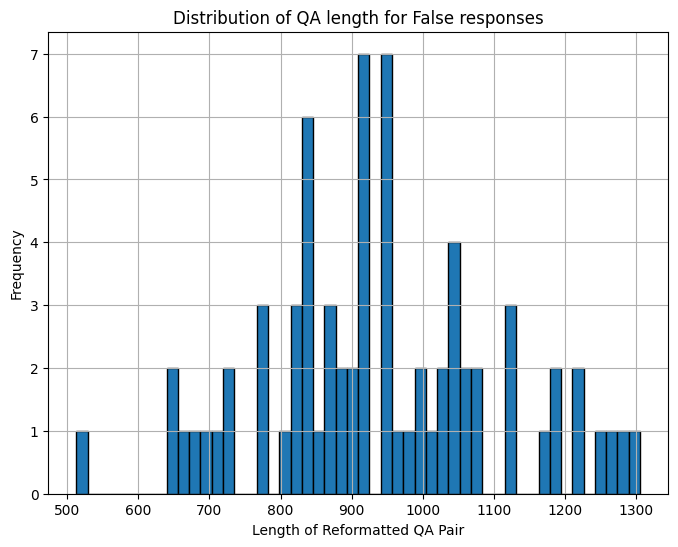

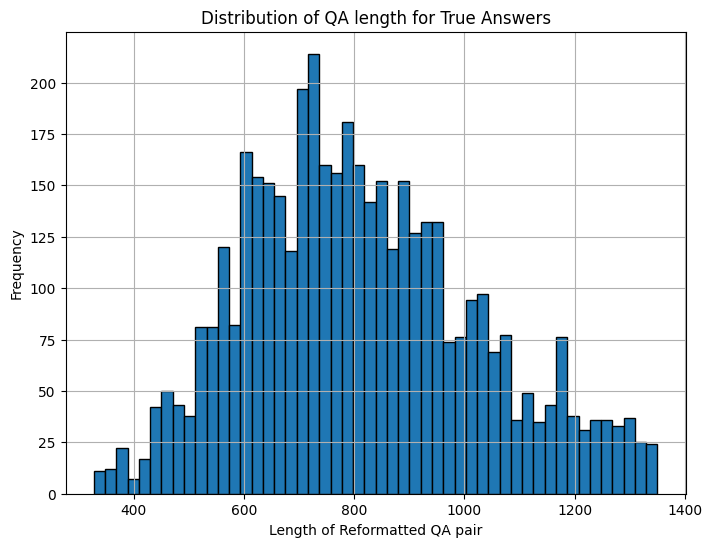

In [ ]:
import csv
import json
import re
import pandas as pd

def process_in_one_script(
    csv_input_path,
    jsonl_path,
    csv_output_path
):
    """
    1) Loads the CSV (model responses).
    2) Extracts numeric answers via regex.
    3) Loads the JSONL (with columns: unique_id, id, gt, etc.).
    4) Merges to get normal 'id' as well as 'gt'.
    5) Labels each row isTrue=1 if correct, else 0.
    6) Outputs a single CSV with correct/incorrect answers labeled.
    """
    
    # 1. Read JSONL into a DataFrame
    df_jsonl = pd.read_json(jsonl_path, lines=True)  # Must specify lines=True
    
    # 2. Read model responses CSV into a DataFrame
    df_csv = pd.read_csv(csv_input_path)
    
    df_csv = pd.concat([df_p2, df_csv], ignore_index=True)
    
    
    # 3. Regex to extract the numeric answer from something like "{123}"
    pattern = re.compile(r"\{([\d.]+)\}")

    
    # 4. Create a new column 'extracted_answer' by applying the regex
    def extract_answer(text):
        match = pattern.search(str(text))
        return match.group(1) if match else ""
    
    df_csv["extracted_answer"] = df_csv["answer"].apply(extract_answer)
    
    # 5. The CSV's 'id' is actually the same as 'unique_id' in the JSONL,
    #    so rename it to allow a merge on that column.
    df_csv.rename(columns={"id": "unique_id"}, inplace=True)
    
    # 6. Merge CSV with JSONL on 'unique_id'.  
    #    We bring in normal 'id' (df_jsonl["id"]) and 'gt' (df_jsonl["gt"]) from the JSONL.
    df_merged = pd.merge(
        df_csv,
        df_jsonl[["unique_id", "id", "gt"]],
        on="unique_id",
        how="left"
    )
    
    # 7. Create an 'isTrue' column: 1 if numeric match, 0 otherwise
    def check_correct(row):
        if row["extracted_answer"] == "":
            return 0
        try:
            ans = float(row["extracted_answer"])
            gt_value = float(row["gt"])
            return 1 if abs(ans - gt_value) < 1e-5 else 0
        except:
            # If there's any parsing error or missing 'gt', mark incorrect
            return 0
    
    df_merged["isTrue"] = df_merged.apply(check_correct, axis=1)
    
    print(df_merged.columns)
    
    # 8. Build final DataFrame in the desired format.
    #    "question" is set to the content of 'answer'.
    df_final = pd.DataFrame({
        "id":       df_merged["id"],             # normal ID from JSONL
        "question": df_merged["answer"],         # question -> from 'answer'
        "gt":       df_merged["gt"],
        "isTrue":   df_merged["isTrue"],
        "isTagged": 1,                           # always 1
        "dataset":  "p2",                        # always "p2"
        "unique_id": df_merged["unique_id"]      # from CSV (which was originally 'id')
    })
    
    #drop long rows
    df_final = df_final[df_final["question"].str.len() <= 1350]
    
    # ---- ADDITION: Drop rows with 'id' in stupid_questions
    stupid_questions = {91, 45, 76, 80, 40}
    df_final = df_final[~df_final["id"].isin(stupid_questions)]

    # ---- ADDITION: Print out value counts of each id where isTrue == 0
    # print("Value counts of id where isTrue == 0:")
    print((df_final["isTrue"] == 0).sum())
    print()
    print(df_final.loc[df_final["isTrue"] == 0, "id"].value_counts())

    # 9. Write the final DataFrame to CSV
    df_final.to_csv(csv_output_path, index=False)
    print(f"Done! Wrote {len(df_final)} rows to {csv_output_path}.")
    
    import matplotlib.pyplot as plt

    # Suppose df_final is the final DataFrame from your script
    df_false = df_final[df_final["isTrue"] == 0].copy()
    df_true = df_final[df_final["isTrue"] == 1].copy()

    # Create a new column for the length of the question
    df_false["question_len"] = df_false["question"].str.len()
    df_true["question_len"] = df_true["question"].str.len()

    # Plot a histogram
    plt.figure(figsize=(8,6))
    df_false["question_len"].hist(bins=50, edgecolor='black')
    plt.title("Distribution of QA length for False responses")
    plt.xlabel("Length of Reformatted QA Pair")
    plt.ylabel("Frequency")
    plt.show()
    
    plt.figure(figsize=(8,6))
    df_true["question_len"].hist(bins=50, edgecolor='black')
    plt.title("Distribution of QA length for True Answers")
    plt.xlabel("Length of Reformatted QA pair")
    plt.ylabel("Frequency")
    plt.show()



csv_input_path = "/Users/log/Github/textual_grounding/logan/results/final/GCoT/GSM_Symbolic/llama3.1405b/gcot_main_test___GSM_Symbolic_llama3.1405b.csv"
jsonl_path = "/Users/log/Github/textual_grounding/data/gsm_symbolic/main_formatted_test.jsonl"
csv_output_path = "/Users/log/Github/grounding_human_preference/data/gsm_symbolic_main.csv"

df_jsonl_test = pd.read_json(jsonl_path, lines=True)
print(df_jsonl_test['unique_id'].nunique())

process_in_one_script(csv_input_path, jsonl_path, csv_output_path)


In [38]:
import pandas as pd

# Paths to your CSV files
old_file = "/Users/log/Github/grounding_human_preference/data/gsm_symbolic.csv"
new_file = "/Users/log/Downloads/GSM_Symbolic_false_responses_updated.csv"

# Read the existing GSM_Symbolic file
df_old = pd.read_csv(old_file)

# Read the new responses file
df_new_resp = pd.read_csv(new_file)

# Create a new DataFrame with the desired columns/transformations
#  - id -> from 'id'
#  - question -> from 'answer'
#  - gt -> from 'gt'
#  - isTrue -> 1
#  - isTagged -> 1
#  - dataset -> "p2"
#  - unique_id -> from 'unique_id'
df_appended_rows = pd.DataFrame({
    "id": df_new_resp["id"],
    "question": df_new_resp["answer"],  # "question" becomes the content of 'answer'
    "gt": df_new_resp["gt"],
    "isTrue": 0,
    "isTagged": 1,
    "dataset": "p2",
    "unique_id": df_new_resp["unique_id"]
})

# Concatenate the new rows onto the original GSM_Symbolic DataFrame
df_combined = pd.concat([df_old, df_appended_rows], ignore_index=True)

# Write the combined DataFrame back to the original CSV (backup your original if needed)
df_combined.to_csv(old_file, index=False)

print("Finished appending updated rows to gsm_symbolic.csv.")


Finished appending updated rows to gsm_symbolic.csv.
